# IBM Data Science Coursera Capstone Project Jupyter Notebook

Author: Mark Hanson

## About this Jupyter notebook
This Jupyter notebook will be used for the final capstone project in the Coursera IBM Data Science Professional class.  In brief the requirements are to leverage Foursquare location data to explore or compare any chosen neighborhoods or cities or to come up with a problem that can be solved with data obtained with the Foursquare API. Unfortunately, Foursquare time-series data is only available to verified managers of Foursquare venues which makes answering some more interesting questions more difficult. In addition, it would seem that Google would have a much more rich dataset which as mentioned in the course is no longer available at a reasonable price. Despite these factors, I have come up with what I think is an interesting project.

#### Description of my capstone project
For my capstone project I have chosen to cluster the cities in the Minneapolis / Saint Paul 7 county metropolitan area similar to what was done in the labs. However, instead of clustering based on similar venues I have chosen to use home valuation data from Zillow to cluster zip codes in the area by similar home values and then add Foursquare venue data for each zip code.

## Introduction
Minneapolis - St. Paul’s (MSP) and the surrounding metropolitan area is home to numerous public and private companies including several on the Fortune 500 list. Some notable companies with headquarters or major operations in the area are United Health Group, Target, Best Buy, US Bank, Well Fargo, Ameriprise Financial, Thrivent Financial, Securian Financial, Supervalu, General Mills, CHS, Cargill, Hormel, Land O Lakes, C.H. Robinson, Xcel Energy, 3M, Medtronic, Honeywell, Ecolab, and Patterson. With such a diverse set of large companies in the MSP area there are bound to people that relocate to the area for work but that are unfamiliar with the different cities and surrounding suburbs that comprise  the MSP metro area.
With over 140 zip codes in the seven county metro, there are a lot of real estate markets to explore.  Realtors can help.  However, while they may be familiar with entire metro area in general, they usually specialize in specific cities and suburbs (i.e. south west metro).
Many factors will come into play when deciding where to start looking for a home to buy.   Location and price range are usually the chief considerations when deciding where to start looking for a home.  But other factors such what types of venues are in the area are also important to many prospective buyers.

<em>Business Problem</em><br>
In an effort to bring some rigor and data science to the problem of characterizing the various suburbs within the MSP metro area, an analysis is presented that clusters the various zip codes that comprise the seven county metro by median home price range.  To add some additional detail, the most prevalent venues in each zip code are added to the median home value cluster data set.

<em>Interested Audience</em><br>
Realtors, prospective buyers, current home owners, residential or commercial developers or anyone seeking to better understand the residential real estate market in the Minneapolis – St. Paul seven county metro will be interested in this data analysis and the results.

## Data

<em>Data Sources</em><br>
To perform this analysis, current and historical residential real estate value data was acquired, analyzed, and joined with both venue data and location data.  Current and historical real estate value data were acquired from Zillow  - an online real estate database company that has data of median home values by zip code available to download for free.  Listings of which zip codes are in the 7 counties - Anoka, Carver, Dakota, Hennepin, Ramsey, Scott, and Washington - that make up the MSP metro area were obtained from Capital Impact  - a site that has a lot of basic civic information about places in the United States.  The source for the latitude and longitude of each of these zip codes is CivicSpace Labs.  GeoJSON data that specifies that polygon shapes for these zip codes originates as U.S. Census  data but was obtained from OpenDataDE  in a GitHub posting.  Finally, venue data was provided by Foursquare.

Zillow’s median home value data for zip codes in Minnesota and Wisconsin were downloaded and imported into a Juypter notebook as a pandas dataframe from a comma separated values (CSV) file.  This was done for expediency in this singular analysis but an application programming interface (API) is also an option for accessing the data as part of an application.  Ultimately this data was filtered down to just data from the seven counties that make up the MSP metro area.

<em>Cleaning Data</em><br>
Since the Zillow data is parsed down to the zip code level as opposed to just the city level – cities can contain multiple zip codes – the Python geolocator library didn’t provide fine enough latitude and longitude resolution for use in characterizing locations with Foursquare data.  To enable searching each zip code in Foursquare, another pandas dataframe was created with data obtained from CivicSpace Labs containing the zip code and latitude and longitude of a centralized point in each zip code in the MSP seven county metro area.  The two dataframes were then merged by matching zip codes resulting in a single dataframe with geocoordinates for each zip code, as well as city, state, county, and current and historical median home value data.

Data attribution (sources):
1. Home value data attribution: “Data acquired from Zillow.com/data on April 10, 2019. Aggregated data on this page is made freely available by Zillow for non-commercial use.”
    - https://www.zillow.com/research/data/
2. Zip code by county source attribution: http://ciclt.net/sn/clt/capitolimpact/gw_default.aspx
3. Zip code centroid data attribution:
    - Dataset Identifier: us-zip-code-latitude-and-longitude
    - License: Creative Commons Attribution-ShareAlike
    - Modified: February 9, 2018 10:31 AM
    - Publisher: CivicSpace Labs
    - Reference: https://boutell.com/zipcodes/
    - Attributions: Copyright 2004 CivicSpace Labs
    - Last processing:
        - February 9, 2018 10:39 AM (metadata)
        - February 9, 2018 10:39 AM (data)
4. Zip code GeoJSON attributions:
    - https://www.census.gov/cgi-bin/geo/shapefiles2010/layers.cgi
    - https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/README.md
5. Foursquare developer API attribution:
    - https://foursquare.com/developers/apps 

#### Install and import packages

In [1]:
# Install geocoder package with conda
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#print('geopy installed!')

In [2]:
# install folium
#!conda install -c conda-forge folium=0.5.0 --yes
#print('folium installed!')

In [3]:
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [4]:
# import other modules
import pandas as pd
from pandas.io.json import json_normalize

import numpy as np
import requests
import json
import bs4
from bs4 import BeautifulSoup as bs

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [5]:
import folium

#### Import Zillow data

1. Home value data attribution: “Data acquired from Zillow.com/data on April 10, 2019. Aggregated data on this page is made freely available by Zillow for non-commercial use.”

NOTE: While working on project, skip down to section MP 3 and import zill_MSP_data.csv or zill_MSP_data_test.csv instead of recreating entire df.

Create a new dataframe with Minneapolis / St. Paul 7 county metro area, drop unused columns, rename ZipCode, and reset index

In [6]:
zill_MNWI_df = pd.read_csv('Zillow_Home_Value_Index_MN_WI.csv')
zill_MN_df = zill_MNWI_df[zill_MNWI_df['State']=='MN']
print(zill_MN_df.shape)
#zill_MN_df.head()

(413, 282)


In [7]:
zill_MN_df = zill_MN_df.drop(['RegionID'], axis=1)
#zill_MN_df = zill_MN_df.drop(zill_MNWI_df.columns.to_series()['1996-04':'2013-12'], axis=1)
zill_MN_df = zill_MN_df.rename(index=str, columns={'RegionName':'ZipCode'})
zill_MN_df.reset_index(drop=True, inplace=True)
#zill_MN_df.head()

In [8]:
zill_MSP_df = zill_MN_df[zill_MN_df['CountyName'].isin(['Anoka County','Carver County','Dakota County','Hennepin County','Ramsey County','Scott County','Washington County'])]

In [9]:
print(zill_MSP_df.shape)
zill_MSP_df.head()

(142, 281)


ZipCode          City State                             Metro  \
1    55124  Apple Valley    MN  Minneapolis-St. Paul-Bloomington   
3    55044     Lakeville    MN  Minneapolis-St. Paul-Bloomington   
4    55337    Burnsville    MN  Minneapolis-St. Paul-Bloomington   
5    55106    Saint Paul    MN  Minneapolis-St. Paul-Bloomington   
6    55303        Ramsey    MN  Minneapolis-St. Paul-Bloomington   

      CountyName  SizeRank   1996-04   1996-05   1996-06   1996-07  ...  \
1  Dakota County       472  118900.0  119400.0  119900.0  120600.0  ...   
3  Dakota County       779  136600.0  136500.0  137000.0  138200.0  ...   
4  Dakota County       806  119800.0  120100.0  120400.0  120700.0  ...   
5  Ramsey County       841   70800.0   70800.0   70900.0   71000.0  ...   
6   Anoka County       850   94800.0   95100.0   95500.0   95800.0  ...   

   2018-05  2018-06  2018-07  2018-08  2018-09  2018-10  2018-11  2018-12  \
1   266300   267600   268100   268800   269800   271000   272300   273900   
3   342800   343900   344300   344400   344700   345900   347400   349000   
4   262700   263800   264400   265400   266300   267300   268600   270300   
5   179900   179900   180100   180100   180000   180700   182200   183600   
6   243200   244200   244800   246400   248500   249800   250800   252100   

   2019-01  2019-02  
1   275600   276800  
3   350600   352000  
4   272100   273500  
5   184700   185600  
6   253900   255200  

[5 rows x 281 columns]

## Methodology
<em>Exploratory Data Analysis</em><br>
At this point in the analysis the latitude and longitude for each zip code were used to obtain venue data for each zip code with the intent of merging it with the median home value data and using a k-means algorithm to cluster the zip codes based on the combined dataset.  k-means clustering machine learning algorithm was chosen because the intent with this data is to find patterns and summarize the unlabeled yet inherently similar data.

Two issues arose while pursuing this approach.  First, some zip codes were identified with no venues at all within the search radius.  Expanding the search radius to 1 mile corrected this problem which is likely due to both rural zip codes having lower venue density and Foursquare venue data being less complete than say Google’s dataset owing to a difference in the number of active users of the respective services.  Second, using a k-means algorithm with a normalized feature set to cluster zip codes on the combined dataset resulted in homogeneity between clusters despite efforts to weight the clustering towards median home value as a differentiating factor.

<em>Modeling</em><br>
While still attempting to cluster the combined home value / venues data set, various numbers of clusters were evaluated using the k_inertia metric.  Graphing k_inertia versus the number of clusters should allow selection of an appropriate value for the number of clusters as the region corresponding to the “knee” or inflection point in the graph where further reductions in k_inertia reaches the point of diminishing returns for further increases in the number of clusters.  Using the combined median home value / venues dataset, no distinct inflection point was observed.
Since clustering on the combined home value / venues dataset did not produce useful results and recalling that price range is the primary factor of interest in the residential real estate market, a shift in approach was made to cluster the data on median home value itself and then merge other data with the clustering result set.  With this approach, k_inertia versus number of clusters had more of an inflection point.  Based on the inflection point the number of clusters to be formed from the k-means algorithm was set to 10.

Choosing 10 clusters produces distinct price ranges as the boxplots of price versus cluster show.  Six of the 10 clusters have between 14 and 24 members (zip codes) the remaining four clusters have 8, 6, 3, and 1 member with the single member cluster clearly being an outlier that belongs in a class by itself.

#### Import Zip Code Centroid Geocoordinates

Notes about geocoordinates:

Originally looped through all the cities in the MSP dataframe and added the latitude and longitude data to the new df using geolocator.  But geolocator uses city and state to get latitude and longitude which results in the same information for all the zip codes in a larger city.  For example, using geolocator results in all 12 zip codes in St. Paul having the same geolocation. Foursquare uses that geolocation to get venue data so all of St. Paul would have the same venues regardless of zip code.  Zillow home value data has data for each zip code.  This mismatch would have obscured the relationship between home values (by zip code) and venues (by city) resulting in poor quality data.  By getting geolocations for each zip code on-line the mismatch can be resolved and each zip code can have an associated list of venues around it.

Found dataset on OpenDataSoft (Civic Space Labs) that links zip code to single geolocation (not boundries as with geoJSON). OpenDataSoft has an API to get data which I used but could only get 100 records which is likely due to a quota limit. Since data is available for download as csv anyway I used a csv to get zipcode centroid data.

2. Zip code centroid data attribution:
    - Dataset Identifier: us-zip-code-latitude-and-longitude
    - License: Creative Commons Attribution-ShareAlike
    - Modified: February 9, 2018 10:31 AM
    - Publisher: CivicSpace Labs
    - Reference: https://boutell.com/zipcodes/
    - Attributions: Copyright 2004 CivicSpace Labs
    - Last processing:
        - February 9, 2018 10:39 AM (metadata)
        - February 9, 2018 10:39 AM (data)

In [10]:
# get geocoordinates for a point in each zipcode
MSP_ZipCode_Geo = pd.read_csv('us-zip-code-latitude-and-longitude.csv', sep=';')
MSP_ZipCode_Geo.drop(columns=['Timezone','Daylight savings time flag', 'geopoint'], inplace=True)
MSP_ZipCode_Geo = MSP_ZipCode_Geo[MSP_ZipCode_Geo['State'].isin(['MN'])]
MSP_ZipCode_Geo.rename(columns={'Zip':'ZipCode'}, inplace=True)
MSP_ZipCode_Geo[MSP_ZipCode_Geo['ZipCode'].isin(zill_MSP_df['ZipCode'])].shape

(141, 5)

Merge MSP_ZipCode_Geo df into zill_MSP_df and reoder columns so latitude and longitude are after city and state.

In [11]:
# merge geocoordinates by zipcode into home value df
zill_MSP_df = pd.merge(zill_MSP_df, MSP_ZipCode_Geo, on=['ZipCode'])

In [12]:
# drop city and state from MSP_ZipCode_Geo as they are less specific that those from zill_MSP_df
zill_MSP_df.drop(columns=['City_y','State_y'], inplace=True)
zill_MSP_df.rename(columns={'City_x' : 'City', 'State_x' : 'State'}, inplace=True)

In [13]:
# move geocoordinates from end columns to right after city name
cols = zill_MSP_df.columns.tolist()
cols = cols[0:2] + cols[-2:] + cols[2:-2]
zill_MSP_df = zill_MSP_df[cols]

In [14]:
print(zill_MSP_df.shape)
zill_MSP_df.head()

(141, 283)


ZipCode          City   Latitude  Longitude State  \
0    55124  Apple Valley  44.743963  -93.20624    MN   
1    55044     Lakeville  44.669564  -93.26654    MN   
2    55337    Burnsville  44.770297  -93.27302    MN   
3    55106    Saint Paul  44.967565  -93.05001    MN   
4    55303        Ramsey  45.247509  -93.41800    MN   

                              Metro     CountyName  SizeRank   1996-04  \
0  Minneapolis-St. Paul-Bloomington  Dakota County       472  118900.0   
1  Minneapolis-St. Paul-Bloomington  Dakota County       779  136600.0   
2  Minneapolis-St. Paul-Bloomington  Dakota County       806  119800.0   
3  Minneapolis-St. Paul-Bloomington  Ramsey County       841   70800.0   
4  Minneapolis-St. Paul-Bloomington   Anoka County       850   94800.0   

    1996-05  ...  2018-05  2018-06  2018-07  2018-08  2018-09  2018-10  \
0  119400.0  ...   266300   267600   268100   268800   269800   271000   
1  136500.0  ...   342800   343900   344300   344400   344700   345900   
2  120100.0  ...   262700   263800   264400   265400   266300   267300   
3   70800.0  ...   179900   179900   180100   180100   180000   180700   
4   95100.0  ...   243200   244200   244800   246400   248500   249800   

   2018-11  2018-12  2019-01  2019-02  
0   272300   273900   275600   276800  
1   347400   349000   350600   352000  
2   268600   270300   272100   273500  
3   182200   183600   184700   185600  
4   250800   252100   253900   255200  

[5 rows x 283 columns]

In [15]:
# write zill_MSP_df to csv so don't have to recreate it everytime using slow geolocator
#zill_MSP_df.to_csv(path_or_buf='zill_MSP_data.csv')

#### Load cleaned data set from CSV while working on project
While working on project, import zill_MSP_data.csv to df instead of re-creating it each time.

In [16]:
# read zill_MSP_df from csv while working on project
zill_MSP_df = pd.read_csv('zill_MSP_data.csv')
zill_MSP_df = zill_MSP_df.drop(columns=['Unnamed: 0'])
print(zill_MSP_df.shape)
zill_MSP_df.head()

(141, 283)


ZipCode          City   Latitude  Longitude State  \
0    55124  Apple Valley  44.743963  -93.20624    MN   
1    55044     Lakeville  44.669564  -93.26654    MN   
2    55337    Burnsville  44.770297  -93.27302    MN   
3    55106    Saint Paul  44.967565  -93.05001    MN   
4    55303        Ramsey  45.247509  -93.41800    MN   

                              Metro     CountyName  SizeRank   1996-04  \
0  Minneapolis-St. Paul-Bloomington  Dakota County       472  118900.0   
1  Minneapolis-St. Paul-Bloomington  Dakota County       779  136600.0   
2  Minneapolis-St. Paul-Bloomington  Dakota County       806  119800.0   
3  Minneapolis-St. Paul-Bloomington  Ramsey County       841   70800.0   
4  Minneapolis-St. Paul-Bloomington   Anoka County       850   94800.0   

    1996-05  ...  2018-05  2018-06  2018-07  2018-08  2018-09  2018-10  \
0  119400.0  ...   266300   267600   268100   268800   269800   271000   
1  136500.0  ...   342800   343900   344300   344400   344700   345900   
2  120100.0  ...   262700   263800   264400   265400   266300   267300   
3   70800.0  ...   179900   179900   180100   180100   180000   180700   
4   95100.0  ...   243200   244200   244800   246400   248500   249800   

   2018-11  2018-12  2019-01  2019-02  
0   272300   273900   275600   276800  
1   347400   349000   350600   352000  
2   268600   270300   272100   273500  
3   182200   183600   184700   185600  
4   250800   252100   253900   255200  

[5 rows x 283 columns]

## Results
With clustering by median home value complete, additional analysis was done and a summary dataframe created to store the results.  Additional analysis included calculating for each cluster a price bin, minimum, median, maximum, and range.  Compound annual growth rate (CAGR) over 5, 10, 15, and 20 year periods were also calculated and added to the summary.  Finally, the top 10 venues within one mile of each zip code approximate geographic center were obtained from Foursquare and added to the summary

#### Cluster the data by the most recent median home value
 - Create a summary data frame of ZipCode, City, Lat, Lng, State, Metro, CountyName, SizeRank, 2019-02 that will be built up through each stage as more summary data is obtained
 - Create a normalized clustering data frame
 - Cluster data by normalized most recent home value and insert cluster labels into summary data frame
 - Create combined vertical box plot of clusters and their associated median home value
 - Create choropleth map of median home value by zip code

Create a summary data frame of ZipCode, City, Lat, Lng, State, Metro, CountyName, SizeRank, 2019-02 that will be built up through each stage as more summary data is obtained

In [17]:
# create a summary data frame
MSP_summary_df = zill_MSP_df.copy(deep=True)
MSP_summary_df = MSP_summary_df.drop(columns=MSP_summary_df.columns.to_series()['1996-04':'2019-01'], axis=1)
MSP_summary_df.head()

ZipCode          City   Latitude  Longitude State  \
0    55124  Apple Valley  44.743963  -93.20624    MN   
1    55044     Lakeville  44.669564  -93.26654    MN   
2    55337    Burnsville  44.770297  -93.27302    MN   
3    55106    Saint Paul  44.967565  -93.05001    MN   
4    55303        Ramsey  45.247509  -93.41800    MN   

                              Metro     CountyName  SizeRank  2019-02  
0  Minneapolis-St. Paul-Bloomington  Dakota County       472   276800  
1  Minneapolis-St. Paul-Bloomington  Dakota County       779   352000  
2  Minneapolis-St. Paul-Bloomington  Dakota County       806   273500  
3  Minneapolis-St. Paul-Bloomington  Ramsey County       841   185600  
4  Minneapolis-St. Paul-Bloomington   Anoka County       850   255200

#### Create a data frame for clustering and evaluate k- means accuracy for various cluster sizes
 - Create a data frame of just median home value for clustering
 - Normalize clustering data frame
 - Evaluate and graph accuracy - as measured by inertia - with various values of k (number of clusters) and select the k value at or around the knee point.

In [18]:
# create a data frame of just median home value
MSP_med_HV = MSP_summary_df.copy(deep=True)
MSP_med_HV = MSP_med_HV.drop(['ZipCode','City','Latitude','Longitude','State','Metro','CountyName','SizeRank'], axis=1)
#MSP_med_HV.head()

In [19]:
# create df with normalized home values in range
scaler = StandardScaler()
MSP_med_HV.iloc[:,0:1] = scaler.fit_transform(MSP_med_HV['2019-02'].values.reshape(-1,1))
MSP_med_HV.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


2019-02
0 -0.321417
1  0.524252
2 -0.358527
3 -1.347016
4 -0.564322

In [85]:
# set number of clusters as range
kclusters = range(1,25)
k_inertia = []
k_val = []

# run k-means clustering
for k in kclusters:
    kmeans = KMeans(init = "k-means++", n_clusters=k, random_state=0).fit(MSP_med_HV)
    k_val.append(k)
    k_inertia.append(kmeans.inertia_)

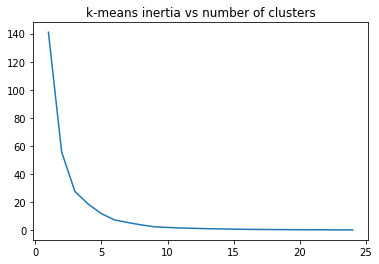

In [86]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# plot k-means inertia (to be minimized) vs number of clusters k. Select knee point in graph
ax.plot(k_val, k_inertia)

# Title of the plot
ax.set_title('k-means inertia vs number of clusters')
#ax.set_ylim(bottom=0, top=1000)
#ax.set_xlim(left=0, right=8)

plt.show()

In [87]:
print(k_inertia[0:25])

[141.00000000000003, 55.70661683438813, 27.604759353113753, 18.63987770572929, 11.800371443012827, 7.259499322407688, 5.45567294446446, 3.7642218802585825, 2.42408721081078, 1.9433419373918, 1.5542862615859017, 1.300090252014484, 1.062904318089997, 0.8891062245122041, 0.7371654949911355, 0.5786608830098515, 0.5051747736945609, 0.44007699556868624, 0.3829910002944777, 0.31891659265492217, 0.2809521874478224, 0.2468524339347951, 0.20339803826714326, 0.1808154811202044]


#### After selecting number of clusters, re-run k-means

In [20]:
kclusters = 10
kmeans = KMeans(init = "k-means++", n_clusters=kclusters, random_state=0).fit(MSP_med_HV)
#kmeans = KMeans(init = "k-means++", n_clusters=kclusters, random_state=0).fit(MSP_grouped_HV_clustering)
cluster_density = pd.Series(kmeans.labels_).value_counts()
cluster_density

0    24
5    23
4    22
8    21
9    19
1    14
7     8
3     6
6     3
2     1
dtype: int64

Insert cluster labels into summary data frame

In [21]:
#MSP_summary_df = MSP_summary_df.drop(columns='ClusterLabel', axis=1)
MSP_summary_df.insert(0,'ClusterLabel', kmeans.labels_)
MSP_summary_df.head()

ClusterLabel  ZipCode          City   Latitude  Longitude State  \
0             8    55124  Apple Valley  44.743963  -93.20624    MN   
1             9    55044     Lakeville  44.669564  -93.26654    MN   
2             8    55337    Burnsville  44.770297  -93.27302    MN   
3             7    55106    Saint Paul  44.967565  -93.05001    MN   
4             0    55303        Ramsey  45.247509  -93.41800    MN   

                              Metro     CountyName  SizeRank  2019-02  
0  Minneapolis-St. Paul-Bloomington  Dakota County       472   276800  
1  Minneapolis-St. Paul-Bloomington  Dakota County       779   352000  
2  Minneapolis-St. Paul-Bloomington  Dakota County       806   273500  
3  Minneapolis-St. Paul-Bloomington  Ramsey County       841   185600  
4  Minneapolis-St. Paul-Bloomington   Anoka County       850   255200

In [22]:
# create Price_Bin, Min, Max, Price_Range columns in df as copies of other columns in df
MSP_summary_df['Price_Bin'] = MSP_summary_df['ClusterLabel']
MSP_summary_df['Price_Min'] = MSP_summary_df['2019-02']
MSP_summary_df['Price_Median'] = MSP_summary_df['2019-02']
MSP_summary_df['Price_Max'] = MSP_summary_df['2019-02']
MSP_summary_df['Price_Range'] = MSP_summary_df['2019-02']

# convert Price_Range to string
MSP_summary_df['Price_Range'] = MSP_summary_df['Price_Range'].apply(str)
# during testing verify data types
#MSP_summary_df.dtypes

In [23]:
# clust_order is order of clusters in ascending order of 2019-02 price range;
# price_bin column is added to and assigned in MSP_summary_df to create cluster labels that will be in ascending order of 2019-02
clust_order = [7,5,0,8,4,9,1,3,6,2]
price_bin = 1

# loop through the cluster order list and set Price_Bin colum equal to price_bin at location in MSP_summary_df where ClusterLabel = i (which is clust_order value), then incr price_bin
# in the same loop set val equal to the 2019-02 value and populate the Price Min, Max, and Range (as string) columns for each cluster
for i in clust_order:
    MSP_summary_df['Price_Bin'].loc[MSP_summary_df['ClusterLabel'] == i] = price_bin
    price_bin += 1
    val = MSP_summary_df.loc[MSP_summary_df['ClusterLabel'] == i, MSP_summary_df.columns[9]]
    MSP_summary_df['Price_Min'].loc[MSP_summary_df['ClusterLabel'] == i] = val.min()
    MSP_summary_df['Price_Median'].loc[MSP_summary_df['ClusterLabel'] == i] = int(val.median())
    MSP_summary_df['Price_Max'].loc[MSP_summary_df['ClusterLabel'] == i] = val.max()
    MSP_summary_df['Price_Range'].loc[MSP_summary_df['ClusterLabel'] == i] = '$'+str(val.min()/1000)+'K - '+str(val.max()/1000)+'K'  #  '${:,.0f}K'.format(med_hv/1000)

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
# while testing drop recently added columns
#MSP_summary_df = MSP_summary_df.drop(columns='Price_Bin')
MSP_summary_df.head(10)

ClusterLabel  ZipCode              City   Latitude  Longitude State  \
0             8    55124      Apple Valley  44.743963  -93.20624    MN   
1             9    55044         Lakeville  44.669564  -93.26654    MN   
2             8    55337        Burnsville  44.770297  -93.27302    MN   
3             7    55106        Saint Paul  44.967565  -93.05001    MN   
4             0    55303            Ramsey  45.247509  -93.41800    MN   
5             8    55113         Roseville  45.011215  -93.15536    MN   
6             5    55104        Saint Paul  44.953665  -93.15922    MN   
7             8    55112      New Brighton  45.076365  -93.19335    MN   
8             9    55416  Saint Louis Park  44.946664  -93.34215    MN   
9             8    55408       Minneapolis  44.947515  -93.28742    MN   

                              Metro       CountyName  SizeRank  2019-02  \
0  Minneapolis-St. Paul-Bloomington    Dakota County       472   276800   
1  Minneapolis-St. Paul-Bloomington    Dakota County       779   352000   
2  Minneapolis-St. Paul-Bloomington    Dakota County       806   273500   
3  Minneapolis-St. Paul-Bloomington    Ramsey County       841   185600   
4  Minneapolis-St. Paul-Bloomington     Anoka County       850   255200   
5  Minneapolis-St. Paul-Bloomington    Ramsey County       948   270900   
6  Minneapolis-St. Paul-Bloomington    Ramsey County       955   234800   
7  Minneapolis-St. Paul-Bloomington    Ramsey County      1007   267700   
8  Minneapolis-St. Paul-Bloomington  Hennepin County      1212   344100   
9  Minneapolis-St. Paul-Bloomington  Hennepin County      1238   286600   

   Price_Bin  Price_Min  Price_Median  Price_Max       Price_Range  
0          4     267700        276800     291700  $267.7K - 291.7K  
1          6     328600        344100     368200  $328.6K - 368.2K  
2          4     267700        276800     291700  $267.7K - 291.7K  
3          1     169600        185650     204100  $169.6K - 204.1K  
4          3     246900        258000     263200  $246.9K - 263.2K  
5          4     267700        276800     291700  $267.7K - 291.7K  
6          2     207200        227600     240200  $207.2K - 240.2K  
7          4     267700        276800     291700  $267.7K - 291.7K  
8          6     328600        344100     368200  $328.6K - 368.2K  
9          4     267700        276800     291700  $267.7K - 291.7K

Price bins were defined to put the clusters in ascending order of price range.  Each price bin was further summarized to again display the price range and median home price of the zip codes that are members of the cluster.  In addition, the top 10 venues for each cluster as a whole were calculated and displayed.

#### Create a vertical box plot of median home value by price bin

[Text(0, 0, '$100K'),
 Text(0, 0, '$200K'),
 Text(0, 0, '$300K'),
 Text(0, 0, '$400K'),
 Text(0, 0, '$500K'),
 Text(0, 0, '$600K'),
 Text(0, 0, '$700K'),
 Text(0, 0, '$800K')]

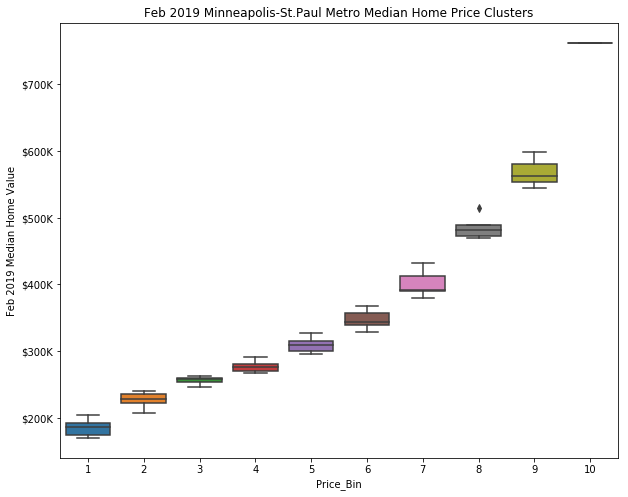

In [25]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(10, 8))
# Create a plot
ax = fig.add_subplot(1, 1, 1)

# create a combined box plot
ax = sns.boxplot(x='Price_Bin', y='2019-02', data=MSP_summary_df)            # order=[7,5,0,8,4,9,1,3,6,2])

ax.set_title('Feb 2019 Minneapolis-St.Paul Metro Median Home Price Clusters')
ax.set_ylabel('Feb 2019 Median Home Value')

vals = ax.get_yticks()/1000
ax.set_yticklabels(['${:,.0f}K'.format(x) for x in vals])

## CAGR and venue calulations. Add these columns to MSP_summary_df

#### Calculate 5, 10, 15, and 20 year compound annual growth rate (CAGR) in median home value by zip code for each zip code in the 7 county Minneapolis-St.Paul metropolitan area
 - Copy relevant median home value data to MSP_CAGR_data df and calculate 5, 10, 15, 20 year CAGR values
 - Create choropleth maps of 5, 10, 15, and 20 year compound annual growth rate in median home value by zip code
 - Insert CAGR data into MSP_summary_df
 - Get top venue data for each zip code
 - Insert top venue for each zip code into MSP_summary_df

In [26]:
CAGR = lambda ev, bv, y : ((ev/bv)**(1/y))-1

cols4 = zill_MSP_df.columns.tolist()
cols4 = cols4[8:42] + cols4[43:102] + cols4[103:162] + cols4 [163:222] + cols4[223:-1] #cols4[10:-1]
#cols4

MSP_CAGR_data = zill_MSP_df.copy(deep=True)
MSP_CAGR_data.drop(columns=cols4, axis=1, inplace=True)
MSP_CAGR_data['ZipCode'] = MSP_CAGR_data['ZipCode'].apply(str)

for i in range(5,25,5):
    MSP_CAGR_data[str(i)+'yrCAGR'] = CAGR(zill_MSP_df[zill_MSP_df.columns[-1]],zill_MSP_df[zill_MSP_df.columns[-1-i*12]],i)

MSP_CAGR_data.head()

ZipCode          City   Latitude  Longitude State  \
0   55124  Apple Valley  44.743963  -93.20624    MN   
1   55044     Lakeville  44.669564  -93.26654    MN   
2   55337    Burnsville  44.770297  -93.27302    MN   
3   55106    Saint Paul  44.967565  -93.05001    MN   
4   55303        Ramsey  45.247509  -93.41800    MN   

                              Metro     CountyName  SizeRank   1999-02  \
0  Minneapolis-St. Paul-Bloomington  Dakota County       472  139100.0   
1  Minneapolis-St. Paul-Bloomington  Dakota County       779  165000.0   
2  Minneapolis-St. Paul-Bloomington  Dakota County       806  138700.0   
3  Minneapolis-St. Paul-Bloomington  Ramsey County       841   84400.0   
4  Minneapolis-St. Paul-Bloomington   Anoka County       850  119700.0   

    2004-02   2009-02   2014-02  2019-02   5yrCAGR  10yrCAGR  15yrCAGR  \
0  226300.0  214600.0  212900.0   276800  0.053897  0.025779  0.013519   
1  288500.0  267600.0  273700.0   352000  0.051607  0.027793  0.013351   
2  225500.0  210500.0  210700.0   273500  0.053558  0.026527  0.012949   
3  162200.0  133400.0  122100.0   185600  0.087358  0.033576  0.009025   
4  200000.0  185800.0  183000.0   255200  0.068774  0.032247  0.016381   

   20yrCAGR  
0  0.035004  
1  0.038611  
2  0.034532  
3  0.040188  
4  0.038578

In [27]:
# insert MSP_CAGR_data into MSP_summary_df
for i in range(5,25,5):
    MSP_summary_df[str(i)+'yrCAGR'] = MSP_CAGR_data[str(i)+'yrCAGR']
MSP_summary_df.head()

ClusterLabel  ZipCode          City   Latitude  Longitude State  \
0             8    55124  Apple Valley  44.743963  -93.20624    MN   
1             9    55044     Lakeville  44.669564  -93.26654    MN   
2             8    55337    Burnsville  44.770297  -93.27302    MN   
3             7    55106    Saint Paul  44.967565  -93.05001    MN   
4             0    55303        Ramsey  45.247509  -93.41800    MN   

                              Metro     CountyName  SizeRank  2019-02  \
0  Minneapolis-St. Paul-Bloomington  Dakota County       472   276800   
1  Minneapolis-St. Paul-Bloomington  Dakota County       779   352000   
2  Minneapolis-St. Paul-Bloomington  Dakota County       806   273500   
3  Minneapolis-St. Paul-Bloomington  Ramsey County       841   185600   
4  Minneapolis-St. Paul-Bloomington   Anoka County       850   255200   

   Price_Bin  Price_Min  Price_Median  Price_Max       Price_Range   5yrCAGR  \
0          4     267700        276800     291700  $267.7K - 291.7K  0.053897   
1          6     328600        344100     368200  $328.6K - 368.2K  0.051607   
2          4     267700        276800     291700  $267.7K - 291.7K  0.053558   
3          1     169600        185650     204100  $169.6K - 204.1K  0.087358   
4          3     246900        258000     263200  $246.9K - 263.2K  0.068774   

   10yrCAGR  15yrCAGR  20yrCAGR  
0  0.025779  0.013519  0.035004  
1  0.027793  0.013351  0.038611  
2  0.026527  0.012949  0.034532  
3  0.033576  0.009025  0.040188  
4  0.032247  0.016381  0.038578

#### Get venue data by zip code and add it to data frame

#### Explore Cities in the 7 county Minneapolis-St.Paul metropolitan area
As in labs, define a function to get FourSquare venue data for all the cities in the Minneapolis-St.Paul metro area. Originally I had issues with rural locations having no venues (too small a radius) and urban locations being clustered together due to too large a radius so experimented with radius and eliminating rural areas by limiting to 7 county metro area. Ultimately selected a 1.61km (1mi) radius around each zip code geolocation and ran query during business hours. Also determined that overly general clusters problem was alleviated by normailzing home values to a wider range of values.

In [28]:
# Four square credentials

In [28]:
# set radius to 1610m (approx 1 mi) and limit search to 100 venues;
def getNearbyVenues(zipcode, names, latitudes, longitudes):
    radius = 1610
    LIMIT = 100   
    
    venues_list=[]
    for zipcode, name, lat, lng in zip(zipcode, names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # deal with case where rural zipcodes are bigger and venues might not be found within 2km so increase to 5km
#        if results == []:
#            radius = 1610
        
        # return only relevant information for each nearby venue                
        venues_list.append([(
            zipcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode','City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the above function on each zip code and create a new dataframe called MSP_venues.

In [30]:
MSP_venues = getNearbyVenues(zipcode = zill_MSP_df['ZipCode'], names = zill_MSP_df['City'], latitudes = zill_MSP_df['Latitude'], longitudes = zill_MSP_df['Longitude'])

In [29]:
print('There are {} uniques categories.'.format(len(MSP_venues['Venue Category'].unique())))

There are 370 uniques categories.


In [34]:
# write MSP_venues df to csv so don't have to recreate it everytime also time dependent last run and saved 12:33 PM 5/1/19
#MSP_venues.to_csv(path_or_buf='MSP_venues_data.csv')

While working on project, import MSP_venues.csv to df instead of re-creating it each time.

In [29]:
# read MSP_venues df from csv so don't have to run as many queries against Foursquare
MSP_venues = pd.read_csv('MSP_venues_data.csv')
MSP_venues = MSP_venues.drop(columns=['Unnamed: 0'])
print(MSP_venues.shape)
MSP_venues.head()

(5187, 8)


ZipCode          City  City Latitude  City Longitude         Venue  \
0    55124  Apple Valley      44.743963       -93.20624     Five Guys   
1    55124  Apple Valley      44.743963       -93.20624    Satay 2 Go   
2    55124  Apple Valley      44.743963       -93.20624     Kwik Trip   
3    55124  Apple Valley      44.743963       -93.20624  Cole's Salon   
4    55124  Apple Valley      44.743963       -93.20624  Jimmy John's   

   Venue Latitude  Venue Longitude      Venue Category  
0       44.735794       -93.216446        Burger Joint  
1       44.731270       -93.201148    Asian Restaurant  
2       44.739600       -93.218739   Convenience Store  
3       44.731770       -93.216405  Salon / Barbershop  
4       44.733264       -93.206591      Sandwich Place

#### Analyze Each Neighborhood

In [30]:
# one hot encoding
MSP_onehot = pd.get_dummies(MSP_venues[['Venue Category']], prefix="", prefix_sep="")

# add zipcode column back to dataframe
MSP_onehot['ZipCode'] = MSP_venues['ZipCode'] 

# move zipcode column to the first column
fixed_columns = [MSP_onehot.columns[-1]] + list(MSP_onehot.columns[:-1])
MSP_onehot = MSP_onehot[fixed_columns]

#MSP_onehot.head()

In [31]:
MSP_onehot.shape

(5187, 371)

In [32]:
# list the average number of venues of each type in each zipcode
MSP_grouped = MSP_onehot.groupby('ZipCode').mean().reset_index()
MSP_grouped.head()

ZipCode  ATM  Accessories Store  Acupuncturist  Adult Boutique  \
0    55001  0.0                0.0            0.0             0.0   
1    55003  0.0                0.0            0.0             0.0   
2    55005  0.0                0.0            0.0             0.0   
3    55011  0.0                0.0            0.0             0.0   
4    55014  0.0                0.0            0.0             0.0   

   Advertising Agency  Afghan Restaurant  African Restaurant  Airport  \
0                 0.0                0.0                 0.0      0.0   
1                 0.0                0.0                 0.0      0.0   
2                 0.0                0.0                 0.0      0.0   
3                 0.0                0.0                 0.0      0.0   
4                 0.0                0.0                 0.0      0.0   

   Airport Service  ...  Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  \
0              0.0  ...                 0.0         0.0       0.0        0.0   
1              0.0  ...                 0.0         0.0       0.0        0.0   
2              0.0  ...                 0.0         0.0       0.0        0.0   
3              0.0  ...                 0.0         0.0       0.0        0.0   
4              0.0  ...                 0.0         0.0       0.0        0.0   

   Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
0     0.0          0.0            0.0          0.0  0.0          0.0  
1     0.0          0.0            0.0          0.0  0.0          0.0  
2     0.0          0.0            0.0          0.0  0.0          0.0  
3     0.0          0.0            0.0          0.0  0.0          0.0  
4     0.0          0.0            0.0          0.0  0.0          0.0  

[5 rows x 371 columns]

Function to sort the venues in descending order.

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe zipcode_venues_sorted to list the top 10 venues for each neighborhood.

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZipCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zipcode_venues_sorted = pd.DataFrame(columns=columns)
zipcode_venues_sorted['ZipCode'] = MSP_grouped['ZipCode']

for ind in np.arange(MSP_grouped.shape[0]):
    zipcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(MSP_grouped.iloc[ind, :], num_top_venues)

print(zipcode_venues_sorted.shape)
zipcode_venues_sorted.head()

(141, 11)


ZipCode 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0    55001    Athletics & Sports           Zoo Exhibit           Dry Cleaner   
1    55003        Breakfast Spot           Video Store    Athletics & Sports   
2    55005        Sandwich Place      Business Service           Gas Station   
3    55011        Hardware Store                Forest           Zoo Exhibit   
4    55014   American Restaurant           Pizza Place        Baseball Field   

     4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0        Electronics Store     Elementary School    English Restaurant   
1  New American Restaurant                   Bar             BBQ Joint   
2              Zoo Exhibit           Dry Cleaner     Electronics Store   
3        Electronics Store     Elementary School    English Restaurant   
4     Fast Food Restaurant           Video Store          Hockey Arena   

   7th Most Common Venue   8th Most Common Venue  9th Most Common Venue  \
0  Entertainment Service    Ethiopian Restaurant            Event Space   
1          Boat or Ferry             Flea Market                Exhibit   
2      Elementary School      English Restaurant  Entertainment Service   
3  Entertainment Service    Ethiopian Restaurant            Event Space   
4                    Bar  Thrift / Vintage Store          Big Box Store   

  10th Most Common Venue  
0                Exhibit  
1     English Restaurant  
2   Ethiopian Restaurant  
3                Exhibit  
4             Playground

Add 10 most common venues for each zip code to MSP_summary_df

In [35]:
# add 10 most common venues for each zip code to MSP_summary_df
MSP_summary_df = MSP_summary_df.join(zipcode_venues_sorted.set_index('ZipCode'), on='ZipCode')
MSP_summary_df.head()

ClusterLabel  ZipCode          City   Latitude  Longitude State  \
0             8    55124  Apple Valley  44.743963  -93.20624    MN   
1             9    55044     Lakeville  44.669564  -93.26654    MN   
2             8    55337    Burnsville  44.770297  -93.27302    MN   
3             7    55106    Saint Paul  44.967565  -93.05001    MN   
4             0    55303        Ramsey  45.247509  -93.41800    MN   

                              Metro     CountyName  SizeRank  2019-02  ...  \
0  Minneapolis-St. Paul-Bloomington  Dakota County       472   276800  ...   
1  Minneapolis-St. Paul-Bloomington  Dakota County       779   352000  ...   
2  Minneapolis-St. Paul-Bloomington  Dakota County       806   273500  ...   
3  Minneapolis-St. Paul-Bloomington  Ramsey County       841   185600  ...   
4  Minneapolis-St. Paul-Bloomington   Anoka County       850   255200  ...   

   1st Most Common Venue  2nd Most Common Venue  3rd Most Common Venue  \
0                   Park            Coffee Shop       Asian Restaurant   
1   Gym / Fitness Center            Golf Course           Home Service   
2            Coffee Shop            Pizza Place                  Hotel   
3     Mexican Restaurant          Grocery Store                   Park   
4             Campground      Convenience Store             Playground   

   4th Most Common Venue 5th Most Common Venue  6th Most Common Venue  \
0           Soccer Field        Sandwich Place   Gym / Fitness Center   
1                   Lake                 Beach           Skating Rink   
2         Sandwich Place    Salon / Barbershop    American Restaurant   
3      Convenience Store        Sandwich Place                    Gym   
4                Dog Run         Big Box Store                   Farm   

   7th Most Common Venue  8th Most Common Venue  9th Most Common Venue  \
0      Convenience Store            Pizza Place     Mexican Restaurant   
1       Department Store        Harbor / Marina              Disc Golf   
2            Video Store                   Park             Smoke Shop   
3   Gym / Fitness Center               Pharmacy            Pizza Place   
4      Elementary School     English Restaurant  Entertainment Service   

  10th Most Common Venue  
0    American Restaurant  
1            Zoo Exhibit  
2           Skating Rink  
3   Fast Food Restaurant  
4   Ethiopian Restaurant  

[5 rows x 29 columns]

In [127]:
#pcols = MSP_summary_df.columns.to_list()
#pcols = pcols[0:3]+pcols[10:15]#+pcols[7:8]+pcols[9:]
#MSP_summary_df[pcols].head()

# Examine Price Bins
 - Create a summary of each price bin's price range, median, and top 5 or 10 venues (this will be different than top 10 venues in each zip code and many not be useful as it aggregates too much)
 - Display a list of all the zip codes in the price bin as a subset of MSP_summary_df

#### Price Bin 1

In [36]:
bin_med = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 1, MSP_summary_df.columns[14]]#, 'Price Range /n', 'Median Home Value'
bin_med.reset_index(inplace=True, drop=True)
med_HV = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 1, MSP_summary_df.columns[9]]

# delcare items for summarizing top venues in all zip codes in Price Range
frames = []
result = pd.DataFrame()
n = 10
i_start = MSP_summary_df.columns.get_loc('1st Most Common Venue')

# loop through columns from 1st most common to nth most common
for i in range(i_start, i_start + n):
    j = i - i_start   # use j to reference count or positions incrementally from 0 to n
    x = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 1, MSP_summary_df.columns[i]]
    df_j = pd.DataFrame(x.value_counts())  # count how many times each venue appears in ith most common
    frames.append(df_j)
    result = pd.concat(frames, axis=1, sort = False)
#   replace NaN with zeros
    result = result.fillna(value=0)

result.insert(0,'Total', result.sum(axis=1))
result = result.sort_values(by=['Total'], ascending=False)

print(' Price Range: ', bin_med[0], '\n', 'Median Home Value : ', '$', '{:,.0f}'.format(med_HV.median()), '\n\n', 'Top 10 Venues in all zip codes in Price Range')
result[['Total']][0:n]

 Price Range:  $169.6K - 204.1K 
 Median Home Value :  $ 185,650 

 Top 10 Venues in all zip codes in Price Range


Total
Park                   7.0
Pizza Place            5.0
Mexican Restaurant     3.0
Coffee Shop            3.0
Grocery Store          3.0
Sandwich Place         3.0
Bar                    3.0
Asian Restaurant       3.0
Theater                2.0
Fried Chicken Joint    2.0

In [37]:
MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 1, MSP_summary_df.columns[list(range(0, MSP_summary_df.shape[1]))]]

ClusterLabel  ZipCode                   City   Latitude  Longitude State  \
3               7    55106             Saint Paul  44.967565  -93.05001    MN   
59              7    55411            Minneapolis  44.999165  -93.29823    MN   
71              7    55412            Minneapolis  45.027715  -93.30337    MN   
76              7    55430        Brooklyn Center  45.059265  -93.29977    MN   
91              7    55107             Saint Paul  44.928315  -93.08876    MN   
96              7    55103             Saint Paul  44.964115  -93.12261    MN   
110             7    55454            Minneapolis  44.969465  -93.24327    MN   
136             7    55368  Norwood Young America  44.756883  -93.91666    MN   

                                Metro       CountyName  SizeRank  2019-02  \
3    Minneapolis-St. Paul-Bloomington    Ramsey County       841   185600   
59   Minneapolis-St. Paul-Bloomington  Hennepin County      4473   175300   
71   Minneapolis-St. Paul-Bloomington  Hennepin County      5323   171800   
76   Minneapolis-St. Paul-Bloomington  Hennepin County      5719   194000   
91   Minneapolis-St. Paul-Bloomington    Ramsey County      7297   192400   
96   Minneapolis-St. Paul-Bloomington    Ramsey County      7763   185700   
110  Minneapolis-St. Paul-Bloomington  Hennepin County      9503   169600   
136  Minneapolis-St. Paul-Bloomington    Carver County     13706   204100   

     ...  1st Most Common Venue  2nd Most Common Venue  3rd Most Common Venue  \
3    ...     Mexican Restaurant          Grocery Store                   Park   
59   ...                   Park   Fast Food Restaurant       Asian Restaurant   
71   ...                   Park           Intersection          Grocery Store   
76   ...                   Park         Discount Store            Pizza Place   
91   ...        Harbor / Marina                   Park     Mexican Restaurant   
96   ...  Vietnamese Restaurant                 Bakery                   Park   
110  ...            Coffee Shop                    Bar                Theater   
136  ...          Bowling Alley         Sandwich Place                    Bar   

     4th Most Common Venue 5th Most Common Venue  6th Most Common Venue  \
3        Convenience Store        Sandwich Place                    Gym   
59                Pharmacy   Fried Chicken Joint            Pizza Place   
71                 Theater      Asian Restaurant                   Road   
76      Chinese Restaurant     Mobile Phone Shop           Intersection   
91          Scenic Lookout                   Bar                   Café   
96          Ice Cream Shop             BBQ Joint        Thai Restaurant   
110            Pizza Place                 Hotel                   Park   
136           Liquor Store        Discount Store     Falafel Restaurant   

     7th Most Common Venue  8th Most Common Venue  9th Most Common Venue  \
3     Gym / Fitness Center               Pharmacy            Pizza Place   
59            Liquor Store             Restaurant  Performing Arts Venue   
71           Train Station            Coffee Shop                 Bakery   
76                   Hotel                  Motel         Shipping Store   
91             Coffee Shop    American Restaurant                    Pub   
96           Grocery Store     Mexican Restaurant            Pizza Place   
110         Scenic Lookout                Brewery    Fried Chicken Joint   
136     English Restaurant  Entertainment Service   Ethiopian Restaurant   

    10th Most Common Venue  
3     Fast Food Restaurant  
59                     ATM  
71      Chinese Restaurant  
76               Speakeasy  
91          Sandwich Place  
96        Asian Restaurant  
110     College Rec Center  
136            Event Space  

[8 rows x 29 columns]

#### Price Bin 2

In [38]:
bin_med = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 2, MSP_summary_df.columns[14]]#, 'Price Range /n', 'Median Home Value'
bin_med.reset_index(inplace=True, drop=True)
med_HV = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 2, MSP_summary_df.columns[9]]

# delcare items for summarizing top venues in all zip codes in Price Range
frames = []
result = pd.DataFrame()
n = 10
i_start = MSP_summary_df.columns.get_loc('1st Most Common Venue')

# loop through columns from 1st most common to nth most common
for i in range(i_start, i_start + n):
    j = i - i_start   # use j to reference count or positions incrementally from 0 to n
    x = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 2, MSP_summary_df.columns[i]]
    df_j = pd.DataFrame(x.value_counts())  # count how many times each venue appears in ith most common
    frames.append(df_j)
    result = pd.concat(frames, axis=1, sort = False)
#   replace NaN with zeros
    result = result.fillna(value=0)

result.insert(0,'Total', result.sum(axis=1))
result = result.sort_values(by=['Total'], ascending=False)

print(' Price Range: ', bin_med[0], '\n', 'Median Home Value : ', '$', '{:,.0f}'.format(med_HV.median()), '\n\n', 'Top 10 Venues in all zip codes in Price Range')
result[['Total']][0:n]

 Price Range:  $207.2K - 240.2K 
 Median Home Value :  $ 227,600 

 Top 10 Venues in all zip codes in Price Range


Total
Park                   15.0
Pizza Place            13.0
Sandwich Place         13.0
Fast Food Restaurant   11.0
Bar                    11.0
Coffee Shop            10.0
Pharmacy                8.0
Chinese Restaurant      7.0
Salon / Barbershop      5.0
Discount Store          5.0

In [39]:
MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 2, MSP_summary_df.columns[list(range(0, MSP_summary_df.shape[1]))]]

ClusterLabel  ZipCode                   City   Latitude  Longitude State  \
6               5    55104             Saint Paul  44.953665  -93.15922    MN   
11              5    55117             Saint Paul  44.989065  -93.10666    MN   
16              5    55119             Saint Paul  44.957315  -93.00616    MN   
23              5    55433            Coon Rapids  45.163848  -93.31950    MN   
25              5    55109              Maplewood  45.010632  -93.01845    MN   
27              5    55432                Fridley  45.095674  -93.25336    MN   
29              5    55404            Minneapolis  44.963365  -93.26179    MN   
31              5    55422            Robbinsdale  45.014764  -93.33965    MN   
34              5    55421       Columbia Heights  45.050434  -93.25007    MN   
38              5    55428               New Hope  45.059997  -93.37702    MN   
42              5    55434                 Blaine  45.164248  -93.25310    MN   
49              5    55448            Coon Rapids  45.186232  -93.29635    MN   
53              5    55429        Brooklyn Center  45.064714  -93.34155    MN   
57              5    55102             Saint Paul  44.935315  -93.12049    MN   
65              5    55076    Inver Grove Heights  44.844833  -93.03528    MN   
72              5    55075       South Saint Paul  44.887966  -93.04546    MN   
94              5    55444          Brooklyn Park  45.106065  -93.30461    MN   
100             5    55425            Bloomington  44.846765  -93.24490    MN   
107             5    56011           Belle Plaine  44.616113  -93.76906    MN   
112             5    55070          Saint Francis  45.395912  -93.37005    MN   
116             5    55071        Saint Paul Park  44.835366  -92.99254    MN   
125             5    55055                Newport  44.871166  -93.00187    MN   
135             5    55397  Norwood Young America  44.801162  -93.92368    MN   

                                Metro         CountyName  SizeRank  2019-02  \
6    Minneapolis-St. Paul-Bloomington      Ramsey County       955   234800   
11   Minneapolis-St. Paul-Bloomington      Ramsey County      1475   213500   
16   Minneapolis-St. Paul-Bloomington      Ramsey County      1687   212700   
23   Minneapolis-St. Paul-Bloomington       Anoka County      2489   229500   
25   Minneapolis-St. Paul-Bloomington      Ramsey County      2549   233600   
27   Minneapolis-St. Paul-Bloomington       Anoka County      2824   227300   
29   Minneapolis-St. Paul-Bloomington    Hennepin County      2846   222900   
31   Minneapolis-St. Paul-Bloomington    Hennepin County      3017   237700   
34   Minneapolis-St. Paul-Bloomington       Anoka County      3146   214900   
38   Minneapolis-St. Paul-Bloomington    Hennepin County      3252   227300   
42   Minneapolis-St. Paul-Bloomington       Anoka County      3438   233900   
49   Minneapolis-St. Paul-Bloomington       Anoka County      3916   239900   
53   Minneapolis-St. Paul-Bloomington    Hennepin County      4001   207200   
57   Minneapolis-St. Paul-Bloomington      Ramsey County      4334   228900   
65   Minneapolis-St. Paul-Bloomington      Dakota County      4936   238200   
72   Minneapolis-St. Paul-Bloomington      Dakota County      5374   214900   
94   Minneapolis-St. Paul-Bloomington    Hennepin County      7573   238300   
100  Minneapolis-St. Paul-Bloomington    Hennepin County      8320   240200   
107  Minneapolis-St. Paul-Bloomington       Scott County      9198   236700   
112  Minneapolis-St. Paul-Bloomington       Anoka County      9906   227600   
116  Minneapolis-St. Paul-Bloomington  Washington County     11002   221200   
125  Minneapolis-St. Paul-Bloomington  Washington County     12475   225400   
135  Minneapolis-St. Paul-Bloomington      Carver County     13632   222700   

     ...  1st Most Common Venue  2nd Most Common Venue  \
6    ...            Coffee Shop   Fast Food Restaurant   
11   ...   Fast Food Restaurant                

#### Price Bin 3

In [40]:
bin_med = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 3, MSP_summary_df.columns[14]]#, 'Price Range /n', 'Median Home Value'
bin_med.reset_index(inplace=True, drop=True)
med_HV = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 3, MSP_summary_df.columns[9]]

# delcare items for summarizing top venues in all zip codes in Price Range
frames = []
result = pd.DataFrame()
n = 10
i_start = MSP_summary_df.columns.get_loc('1st Most Common Venue')

# loop through columns from 1st most common to nth most common
for i in range(i_start, i_start + n):
    j = i - i_start   # use j to reference count or positions incrementally from 0 to n
    x = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 3, MSP_summary_df.columns[i]]
    df_j = pd.DataFrame(x.value_counts())  # count how many times each venue appears in ith most common
    frames.append(df_j)
    result = pd.concat(frames, axis=1, sort = False)
#   replace NaN with zeros
    result = result.fillna(value=0)

result.insert(0,'Total', result.sum(axis=1))
result = result.sort_values(by=['Total'], ascending=False)

print(' Price Range: ', bin_med[0], '\n', 'Median Home Value : ', '$', '{:,.0f}'.format(med_HV.median()), '\n\n', 'Top 10 Venues in all zip codes in Price Range')
result[['Total']][0:n]

 Price Range:  $246.9K - 263.2K 
 Median Home Value :  $ 258,000 

 Top 10 Venues in all zip codes in Price Range


Total
Pizza Place            14.0
Sandwich Place         14.0
American Restaurant    12.0
Coffee Shop            11.0
Park                    8.0
Mexican Restaurant      8.0
Liquor Store            6.0
Fast Food Restaurant    6.0
Bar                     6.0
Chinese Restaurant      5.0

In [41]:
MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 3, MSP_summary_df.columns[list(range(0, MSP_summary_df.shape[1]))]]

ClusterLabel  ZipCode             City   Latitude  Longitude State  \
4               0    55303           Ramsey  45.247509  -93.41800    MN   
13              0    55406      Minneapolis  44.938615  -93.22082    MN   
15              0    55110  White Bear Lake  45.081266  -93.01146    MN   
17              0    55423        Richfield  44.877164  -93.28124    MN   
19              0    55407      Minneapolis  44.934915  -93.25424    MN   
22              0    55418      Minneapolis  45.019315  -93.24304    MN   
28              0    55343          Hopkins  44.921599  -93.40857    MN   
30              0    55118  West Saint Paul  44.903165  -93.10026    MN   
33              0    55016    Cottage Grove  44.830966  -92.93739    MN   
39              0    55128          Oakdale  44.985792  -92.96532    MN   
41              0    55033         Hastings  44.726517  -92.86147    MN   
43              0    55403      Minneapolis  44.971765  -93.28557    MN   
52              0    55427    Golden Valley  45.006764  -93.38223    MN   
63              0    55420      Bloomington  44.837964  -93.27657    MN   
67              0    55316         Champlin  45.170714  -93.38452    MN   
78              0    55344     Eden Prairie  44.867013  -93.42557    MN   
99              0    56071       New Prague  44.546463  -93.57848    MN   
101             0    55445    Brooklyn Park  45.112742  -93.37890    MN   
102             0    55121            Eagan  44.844965  -93.14431    MN   
117             0    55388        Watertown  44.955136  -93.84467    MN   
121             0    55114       Saint Paul  44.964815  -93.19581    MN   
122             0    55005      East Bethel  45.395494  -93.23584    MN   
124             0    55043         Lakeland  44.931600  -92.77001    MN   
137             0    55003          Bayport  45.017767  -92.78039    MN   

                                Metro         CountyName  SizeRank  2019-02  \
4    Minneapolis-St. Paul-Bloomington       Anoka County       850   255200   
13   Minneapolis-St. Paul-Bloomington    Hennepin County      1555   262300   
15   Minneapolis-St. Paul-Bloomington      Ramsey County      1639   263200   
17   Minneapolis-St. Paul-Bloomington    Hennepin County      1743   253600   
19   Minneapolis-St. Paul-Bloomington    Hennepin County      1999   254700   
22   Minneapolis-St. Paul-Bloomington    Hennepin County      2457   259400   
28   Minneapolis-St. Paul-Bloomington    Hennepin County      2837   258000   
30   Minneapolis-St. Paul-Bloomington      Dakota County      2933   260900   
33   Minneapolis-St. Paul-Bloomington  Washington County      3041   259600   
39   Minneapolis-St. Paul-Bloomington  Washington County      3297   252800   
41   Minneapolis-St. Paul-Bloomington      Dakota County      3355   261500   
43   Minneapolis-St. Paul-Bloomington    Hennepin County      3591   258000   
52   Minneapolis-St. Paul-Bloomington    Hennepin County      3966   262800   
63   Minneapolis-St. Paul-Bloomington    Hennepin County      4672   248800   
67   Minneapolis-St. Paul-Bloomington    Hennepin County      5146   255100   
78   Minneapolis-St. Paul-Bloomington    Hennepin County      5882   255100   
99   Minneapolis-St. Paul-Bloomington       Scott County      8081   246900   
101  Minneapolis-St. Paul-Bloomington    Hennepin County      8428   250400   
102  Minneapolis-St. Paul-Bloomington      Dakota County      8500   259800   
117  Minneapolis-St. Paul-Bloomington      Carver County     11036   258700   
121  Minneapolis-St. Paul-Bloomington      Ramsey County     11929   251500   
122  Minneapolis-St. Paul-Bloomington       Anoka County     12002   259300   
124  Minneapolis-St. Paul-Bloomington  Washington County     12426   261300   
137  Minneapolis-St. Paul-Bloomington  Washington County     13770   252400   

     ...    1st Most Common Venue  2nd Most Common Venue  \
4    ...               Campground      Convenience Store   
13   ...              Coffee Shop

#### Price Bin 4

In [42]:
bin_med = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 4, MSP_summary_df.columns[14]]#, 'Price Range /n', 'Median Home Value'
bin_med.reset_index(inplace=True, drop=True)
med_HV = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 4, MSP_summary_df.columns[9]]

# delcare items for summarizing top venues in all zip codes in Price Range
frames = []
result = pd.DataFrame()
n = 10
i_start = MSP_summary_df.columns.get_loc('1st Most Common Venue')

# loop through columns from 1st most common to nth most common
for i in range(i_start, i_start + n):
    j = i - i_start   # use j to reference count or positions incrementally from 0 to n
    x = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 4, MSP_summary_df.columns[i]]
    df_j = pd.DataFrame(x.value_counts())  # count how many times each venue appears in ith most common
    frames.append(df_j)
    result = pd.concat(frames, axis=1, sort = False)
#   replace NaN with zeros
    result = result.fillna(value=0)

result.insert(0,'Total', result.sum(axis=1))
result = result.sort_values(by=['Total'], ascending=False)

print(' Price Range: ', bin_med[0], '\n', 'Median Home Value : ', '$', '{:,.0f}'.format(med_HV.median()), '\n\n', 'Top 10 Venues in all zip codes in Price Range')
result[['Total']][0:n]

 Price Range:  $267.7K - 291.7K 
 Median Home Value :  $ 276,800 

 Top 10 Venues in all zip codes in Price Range


Total
Coffee Shop            12.0
Pizza Place            11.0
Park                   10.0
American Restaurant     9.0
Sandwich Place          9.0
Fast Food Restaurant    6.0
Gym                     6.0
Chinese Restaurant      5.0
Baseball Field          5.0
Mexican Restaurant      4.0

In [43]:
MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 4, MSP_summary_df.columns[list(range(0, MSP_summary_df.shape[1]))]]

ClusterLabel  ZipCode              City   Latitude  Longitude State  \
0               8    55124      Apple Valley  44.743963  -93.20624    MN   
2               8    55337        Burnsville  44.770297  -93.27302    MN   
5               8    55113         Roseville  45.011215  -93.15536    MN   
7               8    55112      New Brighton  45.076365  -93.19335    MN   
9               8    55408       Minneapolis  44.947515  -93.28742    MN   
14              8    55379          Shakopee  44.776138  -93.52556    MN   
18              8    55369       Maple Grove  45.120764  -93.43183    MN   
24              8    55122             Eagan  44.804548  -93.19871    MN   
36              8    55443     Brooklyn Park  45.108581  -93.33988    MN   
37              8    55426  Saint Louis Park  44.952064  -93.37795    MN   
40              8    55024        Farmington  44.649263  -93.15222    MN   
46              8    55417       Minneapolis  44.905365  -93.23662    MN   
54              8    55068         Rosemount  44.732105  -93.13437    MN   
58              8    55014        Lino Lakes  45.153516  -93.14463    MN   
60              8    55025       Forest Lake  45.272117  -92.99110    MN   
73              8    55431       Bloomington  44.829564  -93.30982    MN   
86              8    55108        Saint Paul  44.982515  -93.17489    MN   
89              8    55413       Minneapolis  44.997665  -93.24927    MN   
105             8    55011       East Bethel  45.335128  -93.27434    MN   
108             8    55352            Jordan  44.657463  -93.61330    MN   
134             8    55360             Mayer  44.909362  -93.89981    MN   

                                Metro         CountyName  SizeRank  2019-02  \
0    Minneapolis-St. Paul-Bloomington      Dakota County       472   276800   
2    Minneapolis-St. Paul-Bloomington      Dakota County       806   273500   
5    Minneapolis-St. Paul-Bloomington      Ramsey County       948   270900   
7    Minneapolis-St. Paul-Bloomington      Ramsey County      1007   267700   
9    Minneapolis-St. Paul-Bloomington    Hennepin County      1238   286600   
14   Minneapolis-St. Paul-Bloomington       Scott County      1596   270900   
18   Minneapolis-St. Paul-Bloomington    Hennepin County      1922   274100   
24   Minneapolis-St. Paul-Bloomington      Dakota County      2506   273700   
36   Minneapolis-St. Paul-Bloomington    Hennepin County      3201   269400   
37   Minneapolis-St. Paul-Bloomington    Hennepin County      3242   280300   
40   Minneapolis-St. Paul-Bloomington      Dakota County      3311   278900   
46   Minneapolis-St. Paul-Bloomington    Hennepin County      3809   282500   
54   Minneapolis-St. Paul-Bloomington      Dakota County      4004   281500   
58   Minneapolis-St. Paul-Bloomington       Anoka County      4336   267900   
60   Minneapolis-St. Paul-Bloomington  Washington County      4530   291700   
73   Minneapolis-St. Paul-Bloomington    Hennepin County      5394   277500   
86   Minneapolis-St. Paul-Bloomington      Ramsey County      6716   290100   
89   Minneapolis-St. Paul-Bloomington    Hennepin County      6856   274800   
105  Minneapolis-St. Paul-Bloomington       Anoka County      8998   279100   
108  Minneapolis-St. Paul-Bloomington       Scott County      9317   283100   
134  Minneapolis-St. Paul-Bloomington      Carver County     13590   268000   

     ...       1st Most Common Venue       2nd Most Common Venue  \
0    ...                        Park                 Coffee Shop   
2    ...                 Coffee Shop                 Pizza Place   
5    ...              Clothing Store                 Coffee Shop   
7    ...                       Beach                Home Service   
9    ...                 Coffee Shop                 Pizza Place   
14   ...                         Gym                 Coffee Shop   
18   ...                  Playground          Chinese Restaurant   
24   ...                 Pizza Place             

#### Price Bin 5

In [44]:
bin_med = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 5, MSP_summary_df.columns[14]]#, 'Price Range /n', 'Median Home Value'
bin_med.reset_index(inplace=True, drop=True)
med_HV = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 5, MSP_summary_df.columns[9]]

# delcare items for summarizing top venues in all zip codes in Price Range
frames = []
result = pd.DataFrame()
n = 10
i_start = MSP_summary_df.columns.get_loc('1st Most Common Venue')

# loop through columns from 1st most common to nth most common
for i in range(i_start, i_start + n):
    j = i - i_start   # use j to reference count or positions incrementally from 0 to n
    x = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 5, MSP_summary_df.columns[i]]
    df_j = pd.DataFrame(x.value_counts())  # count how many times each venue appears in ith most common
    frames.append(df_j)
    result = pd.concat(frames, axis=1, sort = False)
#   replace NaN with zeros
    result = result.fillna(value=0)

result.insert(0,'Total', result.sum(axis=1))
result = result.sort_values(by=['Total'], ascending=False)

print(' Price Range: ', bin_med[0], '\n', 'Median Home Value : ', '$', '{:,.0f}'.format(med_HV.median()), '\n\n', 'Top 10 Venues in all zip codes in Price Range')
result[['Total']][0:n]

 Price Range:  $295.2K - 327.0K 
 Median Home Value :  $ 309,200 

 Top 10 Venues in all zip codes in Price Range


Total
Park                  13.0
Pizza Place            9.0
American Restaurant    9.0
Coffee Shop            9.0
Sandwich Place         8.0
English Restaurant     7.0
Bar                    7.0
Elementary School      6.0
Chinese Restaurant     5.0
Grocery Store          5.0

In [45]:
MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 5, MSP_summary_df.columns[list(range(0, MSP_summary_df.shape[1]))]]

ClusterLabel  ZipCode              City   Latitude  Longitude State  \
10              4    55125          Woodbury  44.921982 -92.942340    MN   
12              4    55304           Andover  45.254715 -93.286520    MN   
21              4    55414       Minneapolis  44.980379 -93.230030    MN   
47              4    55126         Shoreview  45.085643 -93.135300    MN   
51              4    55318            Chaska  44.809954 -93.610500    MN   
55              4    55378            Savage  44.761796 -93.372200    MN   
69              4    55437       Bloomington  44.822764 -93.344220    MN   
74              4    55038              Hugo  45.161267 -92.995960    MN   
79              4    55438       Bloomington  44.825700 -93.382120    MN   
81              4    55127   Vadnais Heights  45.076708 -93.082800    MN   
84              4    55401       Minneapolis  44.984615 -93.271370    MN   
85              4    55306        Burnsville  44.732569 -93.289090    MN   
87              4    55364             Mound  44.933712 -93.660380    MN   
93              4    55387           Waconia  44.849912 -93.785140    MN   
98              4    55409       Minneapolis  44.924115 -93.283620    MN   
123             4    55327            Dayton  45.217054 -93.476120    MN   
126             4    55375  Saint Bonifacius  44.906512 -93.743900    MN   
128             4    55020   Elko New Market  44.571365 -93.360110    MN   
129             4    55322           Cologne  44.768762 -93.778390    MN   
138             4    55054   Elko New Market  44.571056 -93.354267    MN   
139             4    55031           Hampton  44.607553 -92.985480    MN   
140             4    55065          Randolph  44.534866 -93.029590    MN   

                                Metro         CountyName  SizeRank  2019-02  \
10   Minneapolis-St. Paul-Bloomington  Washington County      1317   315200   
12   Minneapolis-St. Paul-Bloomington       Anoka County      1544   316100   
21   Minneapolis-St. Paul-Bloomington    Hennepin County      2290   298200   
47   Minneapolis-St. Paul-Bloomington      Ramsey County      3811   300400   
51   Minneapolis-St. Paul-Bloomington      Carver County      3955   297600   
55   Minneapolis-St. Paul-Bloomington       Scott County      4124   302300   
69   Minneapolis-St. Paul-Bloomington    Hennepin County      5301   295200   
74   Minneapolis-St. Paul-Bloomington  Washington County      5494   301200   
79   Minneapolis-St. Paul-Bloomington    Hennepin County      5932   314200   
81   Minneapolis-St. Paul-Bloomington      Ramsey County      6024   327000   
84   Minneapolis-St. Paul-Bloomington    Hennepin County      6384   315200   
85   Minneapolis-St. Paul-Bloomington      Dakota County      6550   302900   
87   Minneapolis-St. Paul-Bloomington    Hennepin County      6720   316000   
93   Minneapolis-St. Paul-Bloomington      Carver County      7558   309100   
98   Minneapolis-St. Paul-Bloomington    Hennepin County      7799   298800   
123  Minneapolis-St. Paul-Bloomington    Hennepin County     12222   301700   
126  Minneapolis-St. Paul-Bloomington    Hennepin County     12476   309300   
128  Minneapolis-St. Paul-Bloomington       Scott County     12843   326000   
129  Minneapolis-St. Paul-Bloomington      Carver County     13074   315800   
138  Minneapolis-St. Paul-Bloomington       Scott County     14743   314700   
139  Minneapolis-St. Paul-Bloomington      Dakota County     14794   314800   
140  Minneapolis-St. Paul-Bloomington      Dakota County     15540   300900   

     ...       1st Most Common Venue  2nd Most Common Venue  \
10   ...              Sandwich Place            Pizza Place   
12   ...                        Park             Restaurant   
21   ...                 Pizza Place            Coffee Shop   
47   ...                   Wine Shop                   Lake   
51   ...              Baseball Field                   Park   
55   ...                         Spa                   Park 

#### Price Bin 6

In [46]:
bin_med = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 6, MSP_summary_df.columns[14]]#, 'Price Range /n', 'Median Home Value'
bin_med.reset_index(inplace=True, drop=True)
med_HV = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 6, MSP_summary_df.columns[9]]

# delcare items for summarizing top venues in all zip codes in Price Range
frames = []
result = pd.DataFrame()
n = 10
i_start = MSP_summary_df.columns.get_loc('1st Most Common Venue')

# loop through columns from 1st most common to nth most common
for i in range(i_start, i_start + n):
    j = i - i_start   # use j to reference count or positions incrementally from 0 to n
    x = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 6, MSP_summary_df.columns[i]]
    df_j = pd.DataFrame(x.value_counts())  # count how many times each venue appears in ith most common
    frames.append(df_j)
    result = pd.concat(frames, axis=1, sort = False)
#   replace NaN with zeros
    result = result.fillna(value=0)

result.insert(0,'Total', result.sum(axis=1))
result = result.sort_values(by=['Total'], ascending=False)

print(' Price Range: ', bin_med[0], '\n', 'Median Home Value : ', '$', '{:,.0f}'.format(med_HV.median()), '\n\n', 'Top 10 Venues in all zip codes in Price Range')
result[['Total']][0:n]

 Price Range:  $328.6K - 368.2K 
 Median Home Value :  $ 344,100 

 Top 10 Venues in all zip codes in Price Range


Total
Coffee Shop                   8.0
Pizza Place                   8.0
Park                          7.0
Video Store                   6.0
Liquor Store                  6.0
Construction & Landscaping    6.0
Lake                          5.0
Elementary School             5.0
American Restaurant           5.0
Electronics Store             5.0

In [47]:
MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 6, MSP_summary_df.columns[list(range(0, MSP_summary_df.shape[1]))]]

ClusterLabel  ZipCode              City   Latitude  Longitude State  \
1               9    55044         Lakeville  44.669564  -93.26654    MN   
8               9    55416  Saint Louis Park  44.946664  -93.34215    MN   
20              9    55082        Stillwater  45.054551  -92.82581    MN   
26              9    55311       Maple Grove  45.102133  -93.48757    MN   
32              9    55372        Prior Lake  44.704646  -93.42139    MN   
35              9    55116        Saint Paul  44.913815  -93.17459    MN   
44              9    55105        Saint Paul  44.934465  -93.16554    MN   
50              9    55449            Blaine  45.168287  -93.20001    MN   
56              9    55305        Minnetonka  44.953763  -93.43346    MN   
62              9    55123             Eagan  44.804048  -93.13378    MN   
68              9    55447          Plymouth  45.003363  -93.49262    MN   
77              9    55441          Plymouth  45.001997  -93.42421    MN   
88              9    55346      Eden Prairie  44.880435  -93.48690    MN   
92              9    55442          Plymouth  45.046701  -93.42892    MN   
95              9    55374            Rogers  45.197646  -93.57104    MN   
109             9    55115         Mahtomedi  45.060048  -92.95762    MN   
119             9    55315            Carver  44.736595  -93.65619    MN   
127             9    55073           Scandia  45.275771  -92.83001    MN   
130             9    55357        Greenfield  45.088013  -93.65053    MN   

                                Metro         CountyName  SizeRank  2019-02  \
1    Minneapolis-St. Paul-Bloomington      Dakota County       779   352000   
8    Minneapolis-St. Paul-Bloomington    Hennepin County      1212   344100   
20   Minneapolis-St. Paul-Bloomington  Washington County      2120   360900   
26   Minneapolis-St. Paul-Bloomington    Hennepin County      2716   368200   
32   Minneapolis-St. Paul-Bloomington       Scott County      3020   332800   
35   Minneapolis-St. Paul-Bloomington      Ramsey County      3156   342700   
44   Minneapolis-St. Paul-Bloomington      Ramsey County      3678   363700   
50   Minneapolis-St. Paul-Bloomington       Anoka County      3940   328600   
56   Minneapolis-St. Paul-Bloomington    Hennepin County      4205   340200   
62   Minneapolis-St. Paul-Bloomington      Dakota County      4624   339000   
68   Minneapolis-St. Paul-Bloomington    Hennepin County      5282   358300   
77   Minneapolis-St. Paul-Bloomington    Hennepin County      5767   332600   
88   Minneapolis-St. Paul-Bloomington    Hennepin County      6757   347400   
92   Minneapolis-St. Paul-Bloomington    Hennepin County      7397   342300   
95   Minneapolis-St. Paul-Bloomington    Hennepin County      7645   331900   
109  Minneapolis-St. Paul-Bloomington  Washington County      9340   364800   
119  Minneapolis-St. Paul-Bloomington      Carver County     11406   341700   
127  Minneapolis-St. Paul-Bloomington  Washington County     12796   350300   
130  Minneapolis-St. Paul-Bloomington    Hennepin County     13312   356600   

     ...  1st Most Common Venue       2nd Most Common Venue  \
1    ...   Gym / Fitness Center                 Golf Course   
8    ...          Grocery Store                 Coffee Shop   
20   ...        Bed & Breakfast         American Restaurant   
26   ...                   Park                       Trail   
32   ...         Baseball Field         American Restaurant   
35   ...            Coffee Shop         American Restaurant   
44   ...            Coffee Shop                      Bakery   
50   ...       Business Service                 Golf Course   
56   ...                    Gym                 Coffee Shop   
62   ...         Baseball Field                 Video Store   
68   ...                   Park                Liquor Store   
77   ...              BBQ Joint                   Locksmith   
88   ...                   Park          Athletics & Sports   
92   ...             

#### Price Bin 7

In [48]:
bin_med = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 7, MSP_summary_df.columns[14]]#, 'Price Range /n', 'Median Home Value'
bin_med.reset_index(inplace=True, drop=True)
med_HV = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 7, MSP_summary_df.columns[9]]

# delcare items for summarizing top venues in all zip codes in Price Range
frames = []
result = pd.DataFrame()
n = 10
i_start = MSP_summary_df.columns.get_loc('1st Most Common Venue')

# loop through columns from 1st most common to nth most common
for i in range(i_start, i_start + n):
    j = i - i_start   # use j to reference count or positions incrementally from 0 to n
    x = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 7, MSP_summary_df.columns[i]]
    df_j = pd.DataFrame(x.value_counts())  # count how many times each venue appears in ith most common
    frames.append(df_j)
    result = pd.concat(frames, axis=1, sort = False)
#   replace NaN with zeros
    result = result.fillna(value=0)

result.insert(0,'Total', result.sum(axis=1))
result = result.sort_values(by=['Total'], ascending=False)

print(' Price Range: ', bin_med[0], '\n', 'Median Home Value : ', '$', '{:,.0f}'.format(med_HV.median()), '\n\n', 'Top 10 Venues in all zip codes in Price Range')
result[['Total']][0:n]

 Price Range:  $379.7K - 431.5K 
 Median Home Value :  $ 392,400 

 Top 10 Venues in all zip codes in Price Range


Total
Park                    6.0
Elementary School       5.0
Electronics Store       5.0
Coffee Shop             5.0
Pizza Place             5.0
American Restaurant     5.0
Golf Course             4.0
Fast Food Restaurant    4.0
Gym                     4.0
Hotel                   3.0

In [49]:
MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 7, MSP_summary_df.columns[list(range(0, MSP_summary_df.shape[1]))]]

ClusterLabel  ZipCode                   City   Latitude  Longitude State  \
45              1    55347           Eden Prairie  44.831413  -93.46031    MN   
48              1    55419            Minneapolis  44.902414  -93.29012    MN   
61              1    55446               Plymouth  45.039312  -93.47988    MN   
64              1    55129               Woodbury  44.896938  -92.90241    MN   
66              1    55345             Minnetonka  44.915413  -93.48443    MN   
75              1    55317             Chanhassen  44.866236  -93.54487    MN   
80              1    55405            Minneapolis  44.971798  -93.30273    MN   
97              1    55077    Inver Grove Heights  44.825391  -93.06893    MN   
111             1    55386               Victoria  44.858595  -93.66341    MN   
114             1    55359           Independence  45.002212  -93.69319    MN   
118             1    55415            Minneapolis  44.973415  -93.25941    MN   
120             1    55120        Mendota Heights  44.873398  -93.14538    MN   
131             1    55384            Spring Park  44.936423  -93.62868    MN   
133             1    55047  Marine on Saint Croix  45.195606  -92.81649    MN   

                                Metro         CountyName  SizeRank  2019-02  \
45   Minneapolis-St. Paul-Bloomington    Hennepin County      3716   409700   
48   Minneapolis-St. Paul-Bloomington    Hennepin County      3855   391700   
61   Minneapolis-St. Paul-Bloomington    Hennepin County      4597   393100   
64   Minneapolis-St. Paul-Bloomington  Washington County      4802   421000   
66   Minneapolis-St. Paul-Bloomington    Hennepin County      5122   383200   
75   Minneapolis-St. Paul-Bloomington      Carver County      5565   390800   
80   Minneapolis-St. Paul-Bloomington    Hennepin County      5965   390500   
97   Minneapolis-St. Paul-Bloomington      Dakota County      7772   407200   
111  Minneapolis-St. Paul-Bloomington      Carver County      9875   431500   
114  Minneapolis-St. Paul-Bloomington    Hennepin County     10622   382800   
118  Minneapolis-St. Paul-Bloomington    Hennepin County     11064   417100   
120  Minneapolis-St. Paul-Bloomington      Dakota County     11854   379700   
131  Minneapolis-St. Paul-Bloomington    Hennepin County     13377   391600   
133  Minneapolis-St. Paul-Bloomington  Washington County     13523   413000   

     ...  1st Most Common Venue       2nd Most Common Venue  \
45   ...                Airport              Scenic Lookout   
48   ...     Mexican Restaurant                 Pizza Place   
61   ...                   Park                 Golf Course   
64   ...                   Food                        Park   
66   ...         Sandwich Place                  Hobby Shop   
75   ...         Sandwich Place         American Restaurant   
80   ...            Coffee Shop                        Park   
97   ...            Coffee Shop  Construction & Landscaping   
111  ...    American Restaurant         Sporting Goods Shop   
114  ...                   Farm           Other Repair Shop   
118  ...            Coffee Shop                       Hotel   
120  ...                   Lake                       Hotel   
131  ...                   Lake             Harbor / Marina   
133  ...                   Lake         Arts & Crafts Store   

          3rd Most Common Venue        4th Most Common Venue  \
45             Airport Terminal                   Food Court   
48                          Gym                 Burger Joint   
61                  Video Store   Construction & Landscaping   
64   Financial or Legal Service                          Gym   
66         Fast Food Restaurant                  Pizza Place   
75                  Pizza Place                  Coffee Shop   
80                  Pizza Place      New American Restaurant   
97        Outdoors & Recreation                          Gym   
111                 Video Store                  Pizza Place   
114          Fala

#### Price Bin 8

In [50]:
bin_med = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 8, MSP_summary_df.columns[14]]#, 'Price Range /n', 'Median Home Value'
bin_med.reset_index(inplace=True, drop=True)
med_HV = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 8, MSP_summary_df.columns[9]]

# delcare items for summarizing top venues in all zip codes in Price Range
frames = []
result = pd.DataFrame()
n = 10
i_start = MSP_summary_df.columns.get_loc('1st Most Common Venue')

# loop through columns from 1st most common to nth most common
for i in range(i_start, i_start + n):
    j = i - i_start   # use j to reference count or positions incrementally from 0 to n
    x = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 8, MSP_summary_df.columns[i]]
    df_j = pd.DataFrame(x.value_counts())  # count how many times each venue appears in ith most common
    frames.append(df_j)
    result = pd.concat(frames, axis=1, sort = False)
#   replace NaN with zeros
    result = result.fillna(value=0)

result.insert(0,'Total', result.sum(axis=1))
result = result.sort_values(by=['Total'], ascending=False)

print(' Price Range: ', bin_med[0], '\n', 'Median Home Value : ', '$', '{:,.0f}'.format(med_HV.median()), '\n\n', 'Top 10 Venues in all zip codes in Price Range')
result[['Total']][0:n]

 Price Range:  $469.5K - 514.2K 
 Median Home Value :  $ 481,350 

 Top 10 Venues in all zip codes in Price Range


Total
Elementary School        3.0
Electronics Store        3.0
Park                     3.0
Entertainment Service    3.0
English Restaurant       3.0
Exhibit                  2.0
Event Space              2.0
Ethiopian Restaurant     2.0
Restaurant               2.0
Business Service         2.0

In [51]:
MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 8, MSP_summary_df.columns[list(range(0, MSP_summary_df.shape[1]))]]

ClusterLabel  ZipCode         City   Latitude  Longitude State  \
70              3    55410  Minneapolis  44.911564  -93.31947    MN   
90              3    55436        Edina  44.903864  -93.37056    MN   
103             3    55042    Lake Elmo  44.999023  -92.90939    MN   
104             3    55439        Edina  44.875997  -93.37021    MN   
113             3    55340       Medina  45.073430  -93.56455    MN   
132             3    55001        Afton  44.903133  -92.81904    MN   

                                Metro         CountyName  SizeRank  2019-02  \
70   Minneapolis-St. Paul-Bloomington    Hennepin County      5316   471200   
90   Minneapolis-St. Paul-Bloomington    Hennepin County      7049   486400   
103  Minneapolis-St. Paul-Bloomington  Washington County      8877   476300   
104  Minneapolis-St. Paul-Bloomington    Hennepin County      8978   514200   
113  Minneapolis-St. Paul-Bloomington    Hennepin County      9962   489900   
132  Minneapolis-St. Paul-Bloomington  Washington County     13401   469500   

     ...  1st Most Common Venue  2nd Most Common Venue  \
70   ...            Coffee Shop     Italian Restaurant   
90   ...                   Park            Coffee Shop   
103  ...             Campground                   Park   
104  ...            Golf Course           Dance Studio   
113  ...                   Pool            Zoo Exhibit   
132  ...     Athletics & Sports            Zoo Exhibit   

          3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
70                         Park            Pizza Place                Bakery   
90           Salon / Barbershop     Seafood Restaurant         Grocery Store   
103  Construction & Landscaping                    Spa                 Trail   
104         American Restaurant      Food & Drink Shop    Seafood Restaurant   
113                        Farm      Electronics Store     Elementary School   
132                 Dry Cleaner      Electronics Store     Elementary School   

     6th Most Common Venue  7th Most Common Venue  8th Most Common Venue  \
70              Restaurant    American Restaurant      French Restaurant   
90          Shipping Store           Liquor Store           Skating Rink   
103       Business Service      Electronics Store      Elementary School   
104          Garden Center                 Bakery                Brewery   
113     English Restaurant  Entertainment Service   Ethiopian Restaurant   
132     English Restaurant  Entertainment Service   Ethiopian Restaurant   

     9th Most Common Venue 10th Most Common Venue  
70          Sandwich Place    Arts & Crafts Store  
90        Business Service            Golf Course  
103     English Restaurant  Entertainment Service  
104             Restaurant   Arts & Entertainment  
113            Event Space                Exhibit  
132            Event Space                Exhibit  

[6 rows x 29 columns]

#### Price Bin 9

In [52]:
bin_med = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 9, MSP_summary_df.columns[14]]#, 'Price Range /n', 'Median Home Value'
bin_med.reset_index(inplace=True, drop=True)
med_HV = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 9, MSP_summary_df.columns[9]]

# delcare items for summarizing top venues in all zip codes in Price Range
frames = []
result = pd.DataFrame()
n = 10
i_start = MSP_summary_df.columns.get_loc('1st Most Common Venue')

# loop through columns from 1st most common to nth most common
for i in range(i_start, i_start + n):
    j = i - i_start   # use j to reference count or positions incrementally from 0 to n
    x = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 9, MSP_summary_df.columns[i]]
    df_j = pd.DataFrame(x.value_counts())  # count how many times each venue appears in ith most common
    frames.append(df_j)
    result = pd.concat(frames, axis=1, sort = False)
#   replace NaN with zeros
    result = result.fillna(value=0)

result.insert(0,'Total', result.sum(axis=1))
result = result.sort_values(by=['Total'], ascending=False)

print(' Price Range: ', bin_med[0], '\n', 'Median Home Value : ', '$', '{:,.0f}'.format(med_HV.median()), '\n\n', 'Top 10 Venues in all zip codes in Price Range')
result[['Total']][0:n]

 Price Range:  $545.1K - 599.2K 
 Median Home Value :  $ 562,800 

 Top 10 Venues in all zip codes in Price Range


Total
Pizza Place          2.0
Sandwich Place       2.0
Lake                 2.0
Liquor Store         2.0
Coffee Shop          2.0
Pet Store            1.0
French Restaurant    1.0
Bakery               1.0
Gas Station          1.0
Chocolate Shop       1.0

In [53]:
MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 9, MSP_summary_df.columns[list(range(0, MSP_summary_df.shape[1]))]]

ClusterLabel  ZipCode       City   Latitude  Longitude State  \
82              6    55331  Shorewood  44.901368  -93.58278    MN   
83              6    55391    Wayzata  44.963063  -93.52912    MN   
115             6    55356      Orono  44.985463  -93.58388    MN   

                                Metro       CountyName  SizeRank  2019-02  \
82   Minneapolis-St. Paul-Bloomington  Hennepin County      6058   562800   
83   Minneapolis-St. Paul-Bloomington  Hennepin County      6317   599200   
115  Minneapolis-St. Paul-Bloomington  Hennepin County     10871   545100   

     ...  1st Most Common Venue  2nd Most Common Venue  3rd Most Common Venue  \
82   ...            Coffee Shop    American Restaurant                   Park   
83   ...          Women's Store             Steakhouse                   Lake   
115  ...            Pizza Place   Gym / Fitness Center           Soccer Field   

     4th Most Common Venue 5th Most Common Venue       6th Most Common Venue  \
82            Liquor Store             Pet Store  Construction & Landscaping   
83                     Gym      Sushi Restaurant          Frozen Yogurt Shop   
115   Fast Food Restaurant   Sporting Goods Shop               Shopping Mall   

     7th Most Common Venue  8th Most Common Venue  9th Most Common Venue  \
82             Pizza Place                 Bakery         Sandwich Place   
83              Restaurant         Chocolate Shop      French Restaurant   
115           Liquor Store            Gas Station         Sandwich Place   

      10th Most Common Venue  
82   New American Restaurant  
83               Coffee Shop  
115                     Lake  

[3 rows x 29 columns]

#### Price Bin 10

In [54]:
bin_med = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 10, MSP_summary_df.columns[14]]#, 'Price Range /n', 'Median Home Value'
bin_med.reset_index(inplace=True, drop=True)
med_HV = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 10, MSP_summary_df.columns[9]]

# delcare items for summarizing top venues in all zip codes in Price Range
frames = []
result = pd.DataFrame()
n = 10
i_start = MSP_summary_df.columns.get_loc('1st Most Common Venue')

# loop through columns from 1st most common to nth most common
for i in range(i_start, i_start + n):
    j = i - i_start   # use j to reference count or positions incrementally from 0 to n
    x = MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 10, MSP_summary_df.columns[i]]
    df_j = pd.DataFrame(x.value_counts())  # count how many times each venue appears in ith most common
    frames.append(df_j)
    result = pd.concat(frames, axis=1, sort = False)
#   replace NaN with zeros
    result = result.fillna(value=0)

result.insert(0,'Total', result.sum(axis=1))
result = result.sort_values(by=['Total'], ascending=False)

print(' Price Range: ', bin_med[0], '\n', 'Median Home Value : ', '$', '{:,.0f}'.format(med_HV.median()), '\n\n', 'Top 10 Venues in all zip codes in Price Range')
result[['Total']][0:n]

 Price Range:  $762.5K - 762.5K 
 Median Home Value :  $ 762,500 

 Top 10 Venues in all zip codes in Price Range


Total
Coffee Shop            1.0
American Restaurant    1.0
Bakery                 1.0
Pizza Place            1.0
French Restaurant      1.0
Restaurant             1.0
Ice Cream Shop         1.0
Grocery Store          1.0
Salon / Barbershop     1.0
Women's Store          1.0

In [55]:
MSP_summary_df.loc[MSP_summary_df['Price_Bin'] == 10, MSP_summary_df.columns[list(range(0, MSP_summary_df.shape[1]))]]

ClusterLabel  ZipCode   City   Latitude  Longitude State  \
106             2    55424  Edina  44.904414  -93.34045    MN   

                                Metro       CountyName  SizeRank  2019-02  \
106  Minneapolis-St. Paul-Bloomington  Hennepin County      9102   762500   

     ...  1st Most Common Venue  2nd Most Common Venue  3rd Most Common Venue  \
106  ...            Coffee Shop    American Restaurant                 Bakery   

     4th Most Common Venue 5th Most Common Venue  6th Most Common Venue  \
106            Pizza Place     French Restaurant             Restaurant   

     7th Most Common Venue  8th Most Common Venue  9th Most Common Venue  \
106         Ice Cream Shop          Grocery Store     Salon / Barbershop   

    10th Most Common Venue  
106          Women's Store  

[1 rows x 29 columns]

## Visualization Section

“Location, location, location” is the saying in real estate – meaning of course that in addition to price, location is an extremely important factor guiding transactions and interest.  With all the analysis summarized in pandas dataframes, visualizations were created to help users better understand the data.  As a starting point, a cluster map, with a circle marker showing which price bin it falls into was created using the folium library.

#### Create a choropleth & cluster map that shows price bin by zip code and has circle markers with pop-ups showing detailed information about price range and venues in each zip code
 - Get MN geoJSON data
 - Create subset of MN geoJSON for Minneapolis-St.Paul metro
 - Create a choropleth map of median home values by zip code
     - Done; but map wasn't as informative as it could be since clusters didn't correspond to anything so worked out price_bins and price min, med, max, range columns above then plotted by price bin
 - Get home value range for each cluster and insert it into MSP_summary_df then plot that instead as combined choro & cluster with pop-ups with stating cluster, median value for that zipcode as well as the price range for the cluster it's in

Get MN geoJSON data and create subset for Minneapolis-St.Paul Metro
 - Import zipcode geojson data for MN from github which used us census data:   
     3. Zip code GeoJSON attributions:
        - https://www.census.gov/cgi-bin/geo/shapefiles2010/layers.cgi
        - https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/README.md

In [56]:
mn_zipcode_file = open('mn_minnesota_zip_codes_geo.json')
mn_zipcode_str = mn_zipcode_file.read()
mn_zipcode_data = json.loads(mn_zipcode_str)

Create a subset of MN geoJSON for just Minneapolis-St.Paul metro zipcodes

In [57]:
# loop through items in state wide zipcode geoJSON file and get just 7 county metro area zipcodes (those in MSP_merged) and write to new geoJSON file
elem = 0 # use to count how many elements
MSP_geoJSON = {'type': 'FeatureCollection', 'features' : []} # dict to store matches; Note had { ... 'features' : dict()} which made features keys vs items as they are now with []

# loop through all the elements in the larger JSON file (which is now stored as a python dict); there is an element for each zipcode in MN
for element in mn_zipcode_data['features']:
    # loop through each zipcode element and look for the property where the zipcode is stored
    for k, v in element['properties'].items():
        if k == 'ZCTA5CE10':
            # loop through each zipcode in MSP_merged dataset
            for postcode in MSP_summary_df['ZipCode']:
                # if the current value from the larger JSON file matches it a zipcode in MSP_merged add the element to MN_geoJSON dict and incr elem
                if str(v) == str(postcode):
                    MSP_geoJSON['features'].append(mn_zipcode_data['features'][elem])  # flaw in logic!! [elem] should be mn_zipcode_data['features'][0 or whatever item number match found!]
            elem += 1    # increment the element count to keep track of how many elements

In [96]:
# write MSP_geoJSON to msp_zipcode_geo.json file
#with open('msp_zipcode_geo.json', 'w') as oufile:
#    json.dump(MSP_geoJSON, oufile)

In [58]:
# read MSP_geoJSON file
msp_zipcode_geo = r'msp_zipcode_geo.json'
#mn_zipcode_geo = r'mn_minnesota_zip_codes_geo.json'

In [59]:
# set st. paul as map starting point
latitude = 44.9537
longitude = -93.0900
#print(latitude, longitude)

In [60]:
# create a new dataframe as a copy of MSP_summary_df. Important change: Converted Zipcode from int64 to string since geoJSON has it stored as a string!
MSP_price_bin = MSP_summary_df.copy(deep=True)
MSP_price_bin['ZipCode'] = MSP_price_bin['ZipCode'].apply(str)

In [61]:
# create a map of minneapolis-st.paul metro area
map_choro_price_bin = folium.Map(location=[latitude, longitude], zoom_start=9)

# generate choropleth map of 2019-02 price bins
map_choro_price_bin.choropleth(
    geo_data=msp_zipcode_geo,
    data=MSP_price_bin,
    columns=['ZipCode','Price_Bin'],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Price_Bin'
)

map_choro_price_bin

While a cluster map helps to show where in the MSP seven county metro area zip codes with similar median home values are located, it isn’t very easy to get that information from quickly.  Adding pop-up boxes for Juypter notebook users to click that list the city, zip code, price range, median home value, compound annual growth rate history, and top 3 venues makes understanding the map easier.

Create cluster map with circle markers and pop-ups with cluster label, city, zip code, and Feb 2019 median home value.

In [62]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, city, zcode, med_hv, cluster, price_range, cagr5, cagr10, cagr15, cagr20, first, second, third\
in zip(MSP_summary_df['Latitude'],
       MSP_summary_df['Longitude'],
       MSP_summary_df['City'],
       MSP_summary_df['ZipCode'],
       MSP_summary_df['2019-02'],
       MSP_summary_df['ClusterLabel'],
       MSP_summary_df['Price_Range'],
       MSP_summary_df['5yrCAGR'],
       MSP_summary_df['10yrCAGR'],
       MSP_summary_df['15yrCAGR'],
       MSP_summary_df['20yrCAGR'],
       MSP_summary_df['1st Most Common Venue'],
       MSP_summary_df['2nd Most Common Venue'],
       MSP_summary_df['3rd Most Common Venue']
      ):
    fancy_label = 'City: '+str(city)+'<br>'+'Zip Code: '+str(zcode)+'<br>'+'Price Range: '+str(price_range)+'<br>'+'Median Value for Zip Code: '+'${:,.0f}K'.format(med_hv/1000)+\
    '<br>'+'<br>'+'CAGRs for Zip Code'+'<br>'+'5 Year: '+'{:,.2%}'.format(cagr5)+'<br>'+'10 Year: '+'{:,.2%}'.format(cagr10)+'<br>'+'15 Year: '+'{:,.2%}'.format(cagr15)+\
    '<br>'+'20 Year: '+'{:,.2%}'.format(cagr20)+'<br>'+'<br>'+'Top 3 venues for Zip Code'+'<br>'+first+'<br>'+second+'<br>'+third
    iframe = folium.IFrame(html=fancy_label, width=300, height=300)
    label = folium.Popup(iframe, max_width=2650, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

But it’s still not as clear as if the data was shown in a choropleth map.  As a next step, a choropleth map was created that keyed on the price bin for the zip code.  Of course choropleth maps require geoJSON data which as noted above was obtained from a GitHub posting by OpenDataDE; the raw underlying data for it coming from the U.S. Census Buerau.  In the GitHub posting geoJSON data was posted by state.  Since only geoJSON data for the zip codes in the MSP seven county metro were required, python code was used to loop through the larger geoJSON file for all of Minnesota and write a smaller geoJSON file for just the seven counties of interest.

One issue of note that arose while creating the choropleth map was that the zip code data in the geoJSON was stored as string datatype while that in the dataframe was stored as int datatype.  Converting one to match the other datatype eliminated the error code from the datatype mismatch.

Choropleth maps make it much easier to see which zip codes fall into which price bins and where they fall geographically.  But this choropleth map lacks the circle marker pop-ups that allow Jupyter notebook users to click on areas of interest to drill down and get more information.  To provide the best of both map types, they were combined into a single map with all the visualizations.

In [63]:
# create a map of minneapolis-st.paul metro area
map_combo = folium.Map(location=[latitude, longitude], zoom_start=9)

# generate choropleth map of 2019-02 price bins
map_combo.choropleth(
    geo_data=msp_zipcode_geo,
    data=MSP_price_bin,
    columns=['ZipCode','Price_Bin'],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Price_Bin'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, city, zcode, med_hv, cluster, price_range, cagr5, cagr10, cagr15, cagr20, first, second, third\
in zip(MSP_summary_df['Latitude'],
       MSP_summary_df['Longitude'],
       MSP_summary_df['City'],
       MSP_summary_df['ZipCode'],
       MSP_summary_df['2019-02'],
       MSP_summary_df['ClusterLabel'],
       MSP_summary_df['Price_Range'],
       MSP_summary_df['5yrCAGR'],
       MSP_summary_df['10yrCAGR'],
       MSP_summary_df['15yrCAGR'],
       MSP_summary_df['20yrCAGR'],
       MSP_summary_df['1st Most Common Venue'],
       MSP_summary_df['2nd Most Common Venue'],
       MSP_summary_df['3rd Most Common Venue']
      ):
    fancy_label = 'City: '+str(city)+'<br>'+'Zip Code: '+str(zcode)+'<br>'+'Price Range: '+str(price_range)+'<br>'+'Median Value for Zip Code: '+'${:,.0f}K'.format(med_hv/1000)+\
    '<br>'+'<br>'+'CAGRs for Zip Code'+'<br>'+'5 Year: '+'{:,.2%}'.format(cagr5)+'<br>'+'10 Year: '+'{:,.2%}'.format(cagr10)+'<br>'+'15 Year: '+'{:,.2%}'.format(cagr15)+\
    '<br>'+'20 Year: '+'{:,.2%}'.format(cagr20)+'<br>'+'<br>'+'Top 3 venues for Zip Code'+'<br>'+first+'<br>'+second+'<br>'+third
    iframe = folium.IFrame(html=fancy_label, width=300, height=300)
    label = folium.Popup(iframe, max_width=2650, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_combo)

map_combo

## Discussion
Zip codes with higher median home values tend to be on the western and southern side of the Minneapolis – St. Paul metro area.  Some possible explanations for this are that these areas are closer to Lake Minnetonka which is valued as a large and beautiful area lake, that there is a well-developed freeway connecting these areas to downtown Minneapolis, and that many of the largest employers are located either in the southwest metro or in downtown Minneapolis.  Minneapolis is west of St. Paul and has a larger business district.  St. Paul is to the east, is the state capital, and as such has more government jobs.  There are, however, a few large employers with operations in the east metro including 3M, Ecolab, and Patterson.

Although more of the zip codes in the southwest metro have higher median value homes, there is also a fairly broad range of median home prices within a commutable distance to virtually anywhere in the seven county MSP area.  In addition, as noted earlier there are similar venues in many of the zip codes in the MSP metro area.  So finding a home in the right price range close to work with the right attractions in the area isn’t usually a problem.

It is noteworthy that there is a substantial variation in the size of the various zip codes with the more urban zip codes being smaller and the more rural zip codes larger.  This size of the search radius used in Foursquare was a mile, which was chosen to be small enough so as not to have significant overlap between zip codes yet large enough to characterize the venues in the zip code.  For some of the very large zip codes the one mile search radius may not adequately characterize the venues encompassed within it.  The location of the zip code centroid could have a big impact on the venues that are found as well.

## Conclusion
The combined choropleth circle marker map with pop-up dialog boxes provides an efficient way to explore the residential real estate market in the Minneapolis – St. Paul metro area and get a high level assessment of current median home prices, historical growth rates, as well as venues that can be found in various zip codes.